# 1) Convert From Cartesian Mesh to Polar Mesh
## Do so for all 20 instantaneous time steps
## Shift Cartesian Mesh by yL or yS
## Interpolate velocity onto uniform polar mesh (mapped to cartesian)
## Visualize the mesh and velocity vectors in polar coordinates

# 2) Plot Streamlines
# 3) Perform Fourier Mode Expansion on Instantaneous Fields

### Imports and Constants

In [1]:
import os,sys
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import pathlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import interpolate

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

#CONSTANTS
dt = 1.0e-3
maxTime = 1000.0
Ntime = int(maxTime/dt)
PERIOD = 0.1
Re = 70.0
RSMALL = 0.15
maxR = 4.0/RSMALL

csfont = {'fontname':'Times New Roman'}
FIGNUM = 0


### 1) Create Cartesian Mesh for velocity field

In [2]:
#Create coordinate field for v(t)
# coordinates of grid endpoints for sphere-centric grid
# and number of points in grid
ax = -maxR
bx =  maxR
ay = -maxR
by =  maxR
m  = 512
# construct sphere meshgrid
sph_x = np.linspace(ax,bx,m)
sph_y = np.linspace(ay,by,m)
mx,my = np.meshgrid(sph_x,sph_y,indexing='xy')

### 2) Store Position Data and Velocity Fields

In [3]:
# constructs a filepath for the pos data of Re = $Re
def pname(Re):
    return "../VelocityFields/Re{:.1f}/pd.txt".format(Re)

# constructs a filename for the ith frame of vel field data
def fname(Re,stem,i):
    return "../VelocityFields/Re{:.1f}/{:s}/res_{:s}_t{:d}.txt".format(Re,stem,stem,i)

#Store and Calculate Vel Field
def getVelField(idxTime):
    arrayUx = np.loadtxt(fname(Re,'Ux',idxTime),skiprows=1)
    arrayUy = np.loadtxt(fname(Re,'Uy',idxTime),skiprows=1)
    flipUx = np.flip(arrayUx,0)
    flipUy = np.flip(arrayUy,0)
    Ux = flipUx.copy()
    Uy = flipUy.copy()
    return Ux,Uy

# pull in timestep information and get which timesteps
# correspond to the current period
ts = np.loadtxt(pname(Re),skiprows=1)
use = np.logical_and(ts[:,-1]>=6.62495,ts[:,-1]<6.72505)
    
# pull out sphere positions for these twenty timesteps
xLcs = ts[use,0]
yLcs = ts[use,1]
xScs = ts[use,2]
yScs = ts[use,3]
xCMcs = xLcs*0.8 + xScs*0.2
yCMcs = yLcs*0.8 + yScs*0.2
    
# slice again to get N many values
nsteps = 20
slice_amt = len(xCMcs)//nsteps
xLcs = xLcs[::slice_amt]/RSMALL
yLcs = yLcs[::slice_amt]/RSMALL
xScs = xScs[::slice_amt]/RSMALL
yScs = yScs[::slice_amt]/RSMALL
xCMcs = xCMcs[::slice_amt]/RSMALL
yCMcs = yCMcs[::slice_amt]/RSMALL

#Assign Cartesian mesh shift values
#For all 20 timesteps
#Currently Large sphere
xShift, yShift = np.zeros(20), np.zeros(20)
for idx in range(20):
    xShift[idx], yShift[idx] = 0.5*(xScs[idx]+xLcs[idx]), 0.5*(yScs[idx]+yLcs[idx])
    print('yShift[%i] = %.3f'%(idx,yShift[idx]))

# get sphere-centric fields
nTime = 20    
nDim = 2
nX = m
nY = m
#Create an array for files Ux, Uy
#For all 20 timesteps
dataU = np.zeros((nTime,nDim,nY,nX))
for idxTime in range(nTime):
    dataU[idxTime,0],dataU[idxTime,1] = getVelField(idxTime)
    print(dataU[idxTime,0].shape)
    
#Calculate Average Fields
avgU = np.zeros((nDim,nX,nY))
for idxTime in range(nTime):
    avgU += dataU[idxTime]/20.0
print('Average')
print(avgU[0].shape)

#Interpolate for Avg data
avgxShift, avgyShift = np.mean(xCMcs), np.mean(yCMcs)
    

yShift[0] = 4.260
yShift[1] = 4.294
yShift[2] = 4.360
yShift[3] = 4.453
yShift[4] = 4.564
yShift[5] = 4.684
yShift[6] = 4.803
yShift[7] = 4.910
yShift[8] = 4.996
yShift[9] = 5.052
yShift[10] = 5.074
yShift[11] = 5.060
yShift[12] = 5.014
yShift[13] = 4.941
yShift[14] = 4.849
yShift[15] = 4.750
yShift[16] = 4.654
yShift[17] = 4.571
yShift[18] = 4.509
yShift[19] = 4.477
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
Average
(512, 512)


### 3) Calculate new cartesian mesh and interpolate onto a polar mesh centered around (xShift, yShift)

In [4]:
def InterpolateToNewCoordinateSystem(mx,my,arrayUx,arrayUy):
    #Create a uniform polar mesh for the interpolated velocity vectors!
    r = np.linspace(0.0,maxR,512)
    t = np.linspace(0.0,2.0*np.pi-np.pi/256.0,512)
    mr, mt = np.meshgrid(r,t)

    #Convert uniform polar mesh to cartesian coordinate system
    mx_new = mr*np.cos(mt)
    my_new = mr*np.sin(mt)

    print('mx_new = ',mx_new)
    print('my_new = ',my_new)

    #Interpolate Ux and Uy from original cartesian coordainates to new ones
    #Griddata
    arrayUx_new=interpolate.griddata((mx.flatten(),my.flatten()),arrayUx.flatten() , (mx_new,my_new),method='cubic')
    arrayUy_new=interpolate.griddata((mx.flatten(),my.flatten()),arrayUy.flatten() , (mx_new,my_new),method='cubic')

    #Convert Interpolated Ux And Uy to Polar Coordinates
    arrayUr = arrayUx_new*np.cos(mt) + arrayUy_new*np.sin(mt)
    arrayUt = -1.0*arrayUx_new*np.sin(mt) + arrayUy_new*np.cos(mt)

    print('Coordinate Transformation Complete!')
    return (mx_new,my_new,arrayUx_new,arrayUy_new,arrayUr,arrayUt)

#Create vectors for shifted and interpolated mesh data
#Create Average meshes (New and Polar)
newavgMesh = np.zeros((nDim,nY,nX))
newavgU_cart = np.zeros((nDim,nY,nX))
newavgU_polar = np.zeros((nDim,nY,nX))

avgmx_shifted, avgmy_shifted = mx.copy() - avgxShift, my.copy() - avgyShift
newavgMesh[0],newavgMesh[1],newavgU_cart[0],newavgU_cart[1],newavgU_polar[0],newavgU_polar[1] = InterpolateToNewCoordinateSystem(avgmx_shifted,avgmy_shifted,avgU[0],avgU[1])
print('Done with Interpolation')

#Calculate in Swimmer's frame
#Find the instantaneous interpolations
#Then average flow field on polar grid
#Shift instantaneous flow
newMesh = np.zeros((nTime,nDim,nY,nX))
newU_cart = np.zeros((nTime,nDim,nY,nX))
newU_polar = np.zeros((nTime,nDim,nY,nX))
#Loop over all timesteps and interpolate onto polar mesh
for idxTime in range(nTime):
    #Interpolate for instantaneous data
    print('idxTime = ',idxTime)
    mx_shifted, my_shifted = mx.copy() - xShift[idxTime], my.copy() - yShift[idxTime]
    newMesh[idxTime,0],newMesh[idxTime,1],newU_cart[idxTime,0],newU_cart[idxTime,1],newU_polar[idxTime,0],newU_polar[idxTime,1] = InterpolateToNewCoordinateSystem(mx_shifted,my_shifted,dataU[idxTime,0],dataU[idxTime,1])
#Now average Ur and Ut for instantaneous flows
#And new U_cart
CM_avgU_cart = np.zeros((nDim,nY,nX))
CM_avgU_polar = np.zeros((nDim,nY,nX))
for idxTime in range(nTime):
    CM_avgU_cart += newU_cart[idxTime]/nTime
    CM_avgU_polar += newU_polar[idxTime]/nTime

mx_new =  [[  0.           0.05218526   0.10437052 ...,  26.56229615  26.61448141
   26.66666667]
 [  0.           0.05218133   0.10436266 ...,  26.56029606  26.61247739
   26.66465872]
 [  0.           0.05216954   0.10433908 ...,  26.55429608  26.60646562
   26.65863517]
 ..., 
 [  0.           0.0521499    0.10429979 ...,  26.54429713  26.59644703
   26.64859692]
 [  0.           0.05216954   0.10433908 ...,  26.55429608  26.60646562
   26.65863517]
 [  0.           0.05218133   0.10436266 ...,  26.56029606  26.61247739
   26.66465872]]
my_new =  [[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   6.40393387e-04   1.28078677e-03 ...,   3.25960234e-01
    3.26600628e-01   3.27241021e-01]
 [  0.00000000e+00   1.28069033e-03   2.56138067e-03 ...,   6.51871380e-01
    6.53152070e-01   6.54432761e-01]
 ..., 
 [ -0.00000000e+00  -1.92079441e-03  -3.84158883e-03 ...,  -9.77684356e-01
   -9.79605151e-01  -9.815

Coordinate Transformation Complete!
idxTime =  6
mx_new =  [[  0.           0.05218526   0.10437052 ...,  26.56229615  26.61448141
   26.66666667]
 [  0.           0.05218133   0.10436266 ...,  26.56029606  26.61247739
   26.66465872]
 [  0.           0.05216954   0.10433908 ...,  26.55429608  26.60646562
   26.65863517]
 ..., 
 [  0.           0.0521499    0.10429979 ...,  26.54429713  26.59644703
   26.64859692]
 [  0.           0.05216954   0.10433908 ...,  26.55429608  26.60646562
   26.65863517]
 [  0.           0.05218133   0.10436266 ...,  26.56029606  26.61247739
   26.66465872]]
my_new =  [[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   6.40393387e-04   1.28078677e-03 ...,   3.25960234e-01
    3.26600628e-01   3.27241021e-01]
 [  0.00000000e+00   1.28069033e-03   2.56138067e-03 ...,   6.51871380e-01
    6.53152070e-01   6.54432761e-01]
 ..., 
 [ -0.00000000e+00  -1.92079441e-03  -3.84158883e-03

Coordinate Transformation Complete!
idxTime =  13
mx_new =  [[  0.           0.05218526   0.10437052 ...,  26.56229615  26.61448141
   26.66666667]
 [  0.           0.05218133   0.10436266 ...,  26.56029606  26.61247739
   26.66465872]
 [  0.           0.05216954   0.10433908 ...,  26.55429608  26.60646562
   26.65863517]
 ..., 
 [  0.           0.0521499    0.10429979 ...,  26.54429713  26.59644703
   26.64859692]
 [  0.           0.05216954   0.10433908 ...,  26.55429608  26.60646562
   26.65863517]
 [  0.           0.05218133   0.10436266 ...,  26.56029606  26.61247739
   26.66465872]]
my_new =  [[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   6.40393387e-04   1.28078677e-03 ...,   3.25960234e-01
    3.26600628e-01   3.27241021e-01]
 [  0.00000000e+00   1.28069033e-03   2.56138067e-03 ...,   6.51871380e-01
    6.53152070e-01   6.54432761e-01]
 ..., 
 [ -0.00000000e+00  -1.92079441e-03  -3.84158883e-0

Coordinate Transformation Complete!


### 4) Check if new mesh is calculated correctly
#### Plot shifted and interpolated velocity fields

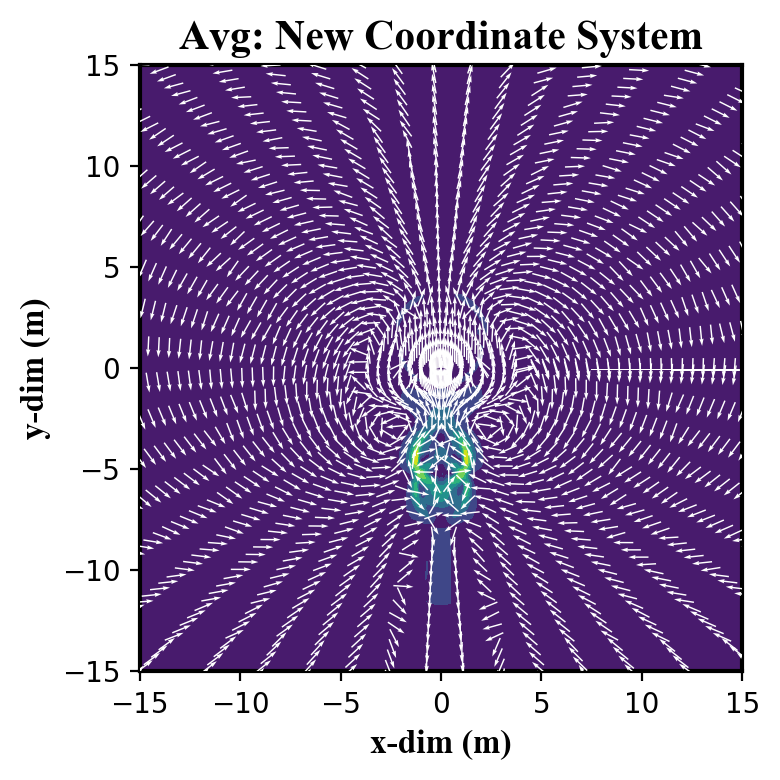

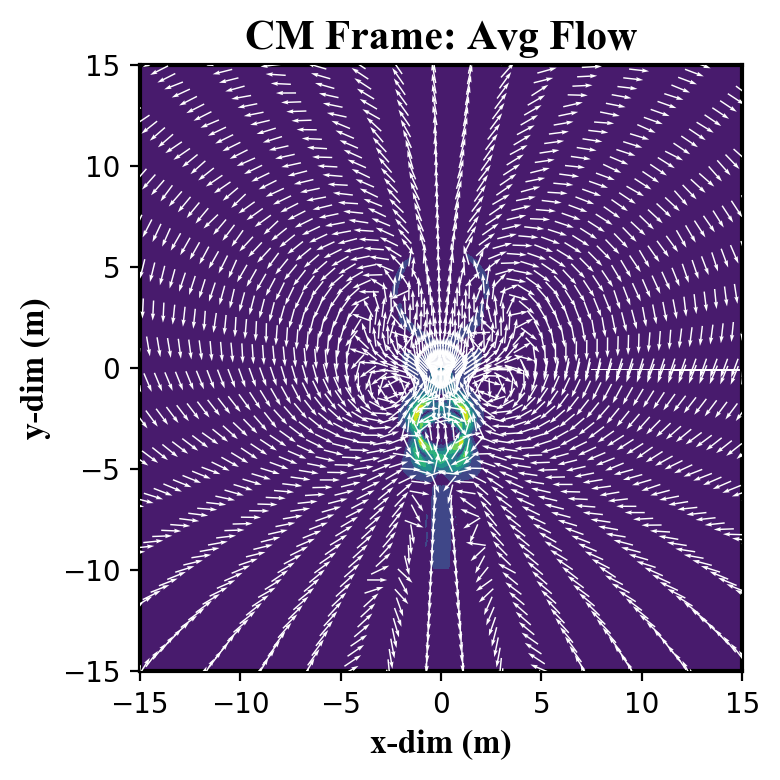

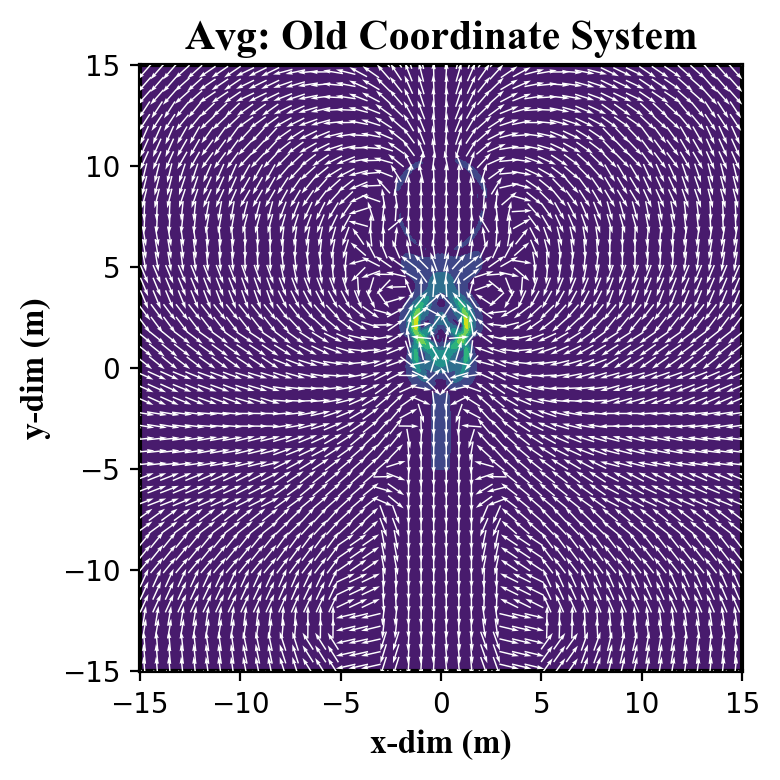

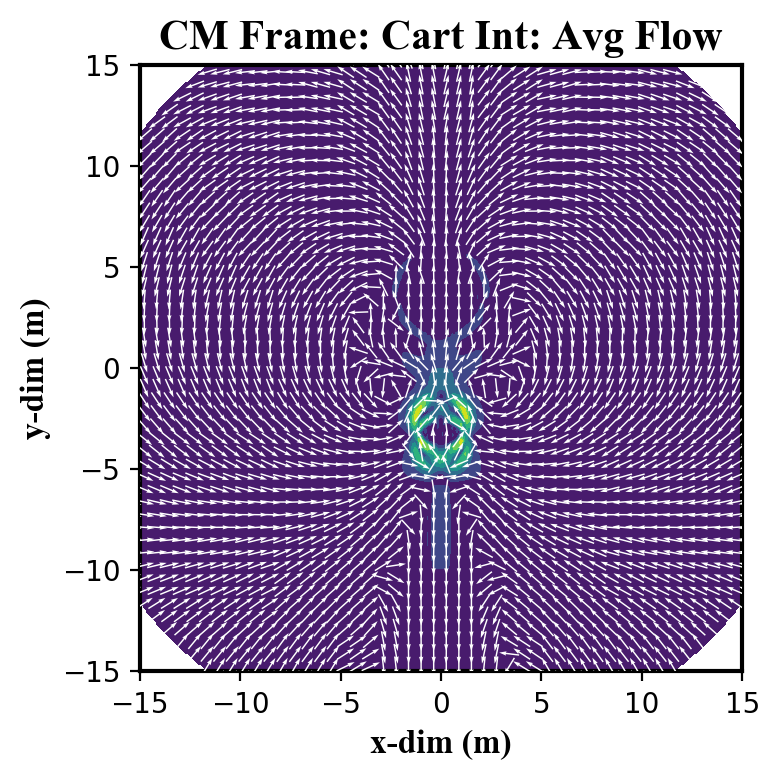

In [7]:
#Plot New Ux and Uy
def PlotInterpolatedU(mx,my,Ux,Uy,title,spacing):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(4,4),dpi=200)
    ax = fig.add_subplot(111)
    #We will specify the time in the x-label
    ax.set_title(title,fontsize=15,**csfont)
    ax.set_xlabel('x-dim (m)',fontsize=12,**csfont)
    ax.set_ylabel('y-dim (m)',fontsize=12,**csfont)
    #Now that we have the figure all labeled, let's add the force field
    space = spacing
    normUx,normUy = Ux/np.hypot(Ux,Uy),Uy/np.hypot(Ux,Uy)
    magU = np.hypot(Ux,Uy)
    '''img = ax.imshow(magU,interpolation='none',cmap='viridis',
               extent=[-4,4,-4,4],
               #vmin = 0, vmax = 10,
               origin='lower',aspect='equal')'''
    ax.quiver(mx[::space,::space],my[::space,::space],
              normUx[::space,::space],normUy[::space,::space],
              color='white',pivot='mid',scale=30,zorder=5)
    ax.contourf(mx,my,magU,cmap='viridis')
    #ax.scatter(mx,my,c=magU,cmap='viridis',s=10)
    ax.axis([-15.0,15.0,-15.0,15.0])
    #ax.axis([-4,4,-4,4])
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close()
    return

#Average Plotting
plotTitle = 'Avg: New Coordinate System'
PlotInterpolatedU(newavgMesh[0],newavgMesh[1],newavgU_cart[0],newavgU_cart[1],plotTitle,10)

#Check CM frame
r = np.linspace(0.0,maxR,512)
t = np.linspace(0.0,2.0*np.pi-np.pi/256.0,512)
mr, mt = np.meshgrid(r,t)
#Convert uniform polar mesh to cartesian coordinate system
mx_new = mr*np.cos(mt)
my_new = mr*np.sin(mt)
plotTitle = 'CM Frame: Avg Flow'
PlotInterpolatedU(mx_new,my_new,CM_avgU_cart[0],CM_avgU_cart[1],plotTitle,10)

#Average Cartesian
plotTitle = 'Avg: Old Coordinate System'
PlotInterpolatedU(mx,my,avgU[0],avgU[1],plotTitle,6)

#Interpolate Ux and Uy from original cartesian coordainates to new ones
#Griddata
mx2_new = mx_new[mr < 19.0]
my2_new = my_new[mr < 19.0]
CM_avgUx = CM_avgU_cart[0].copy()
CM_avgUy = CM_avgU_cart[1].copy()
CM_avgUx2 = CM_avgUx[mr < 19.0]
CM_avgUy2 = CM_avgUy[mr < 19.0]
U_CM_avgUx_cart=interpolate.griddata((mx2_new.flatten(),my2_new.flatten()),CM_avgUx2.flatten() , (mx,my),method='cubic')
U_CM_avgUy_cart=interpolate.griddata((mx2_new.flatten(),my2_new.flatten()),CM_avgUy2.flatten() , (mx,my),method='cubic')
plotTitle = 'CM Frame: Cart Int: Avg Flow'
PlotInterpolatedU(mx,my,U_CM_avgUx_cart,U_CM_avgUy_cart,plotTitle,6)


### 5) Plot Streamlines for instantaneous fields

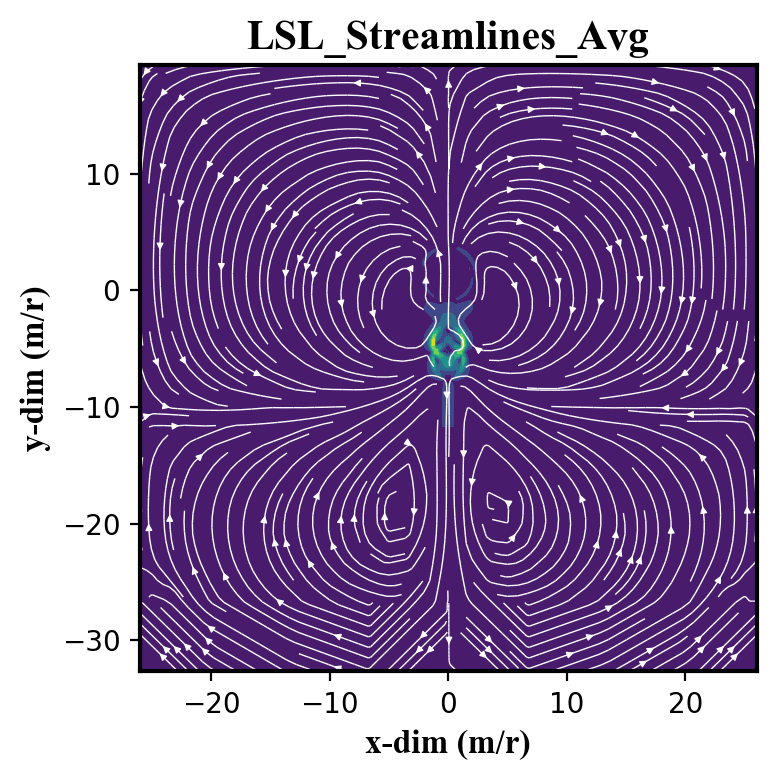

In [15]:
#Make a StreamLine Plot
def PlotStreamsU(mx,my,Ux,Uy,title):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(4,4),dpi=200)
    ax = fig.add_subplot(111)
    #We will specify the time in the x-label
    ax.set_title(title,fontsize=15,**csfont)
    ax.set_xlabel('x-dim (m/r)',fontsize=12,**csfont)
    ax.set_ylabel('y-dim (m/r)',fontsize=12,**csfont)
    #Now that we have the figure all labeled, let's add the force field
    space = 5
    magU = np.hypot(Ux,Uy)
    ax.contourf(mx,my,magU,cmap='viridis')
    ax.streamplot(mx,my,Ux,Uy,color='white',linewidth=0.5,arrowsize=0.5,density=2.0)
    #ax.axis([-2.0,2.0,-3.0,1.0])
    ax.axis([-3.9/RSMALL,3.9/RSMALL,-4.9/RSMALL,2.9/RSMALL])
    fig.tight_layout()
    plt.show()
    fig.savefig(title+'.png')
    fig.clf()
    plt.close()
    return

#Instantaneous Plotting
#PlotStreamsU(mx,my,dataU,yShift)

#Average Plotting
title = 'LSL_Streamlines_Avg'
PlotStreamsU(avgmx_shifted,avgmy_shifted,avgU[0],avgU[1],title)


### 6) Perform Fourier Mode Expansion on Instantaneous Velocity Field
### Field must use polar coordinates

/Users/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


num mt_list =  217600
num set_t =  512


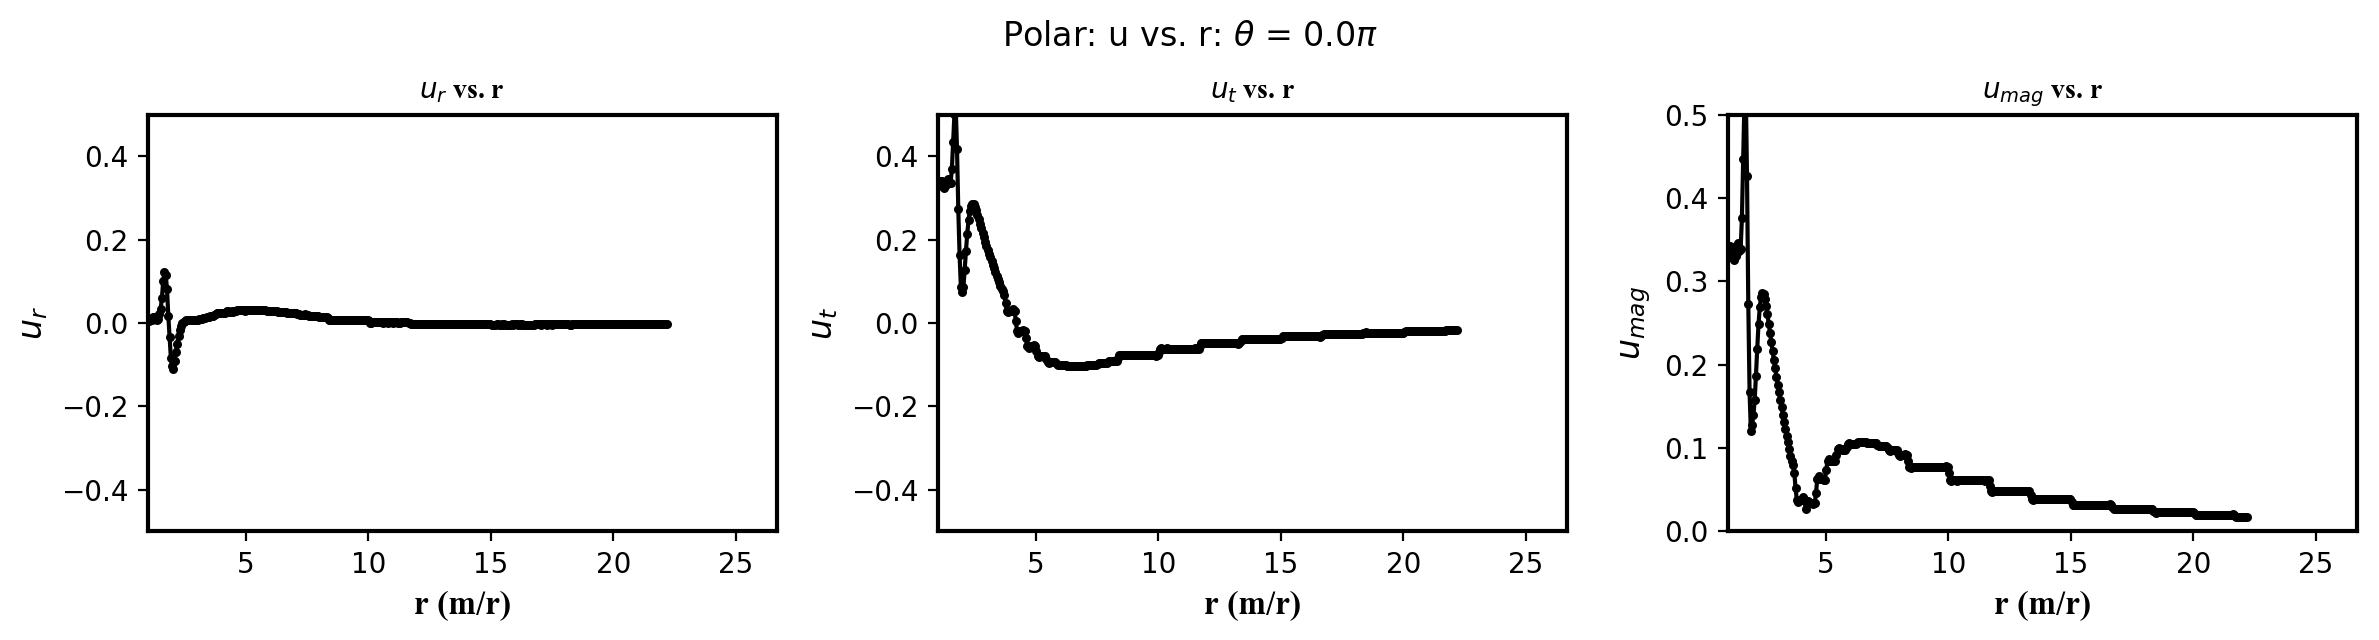

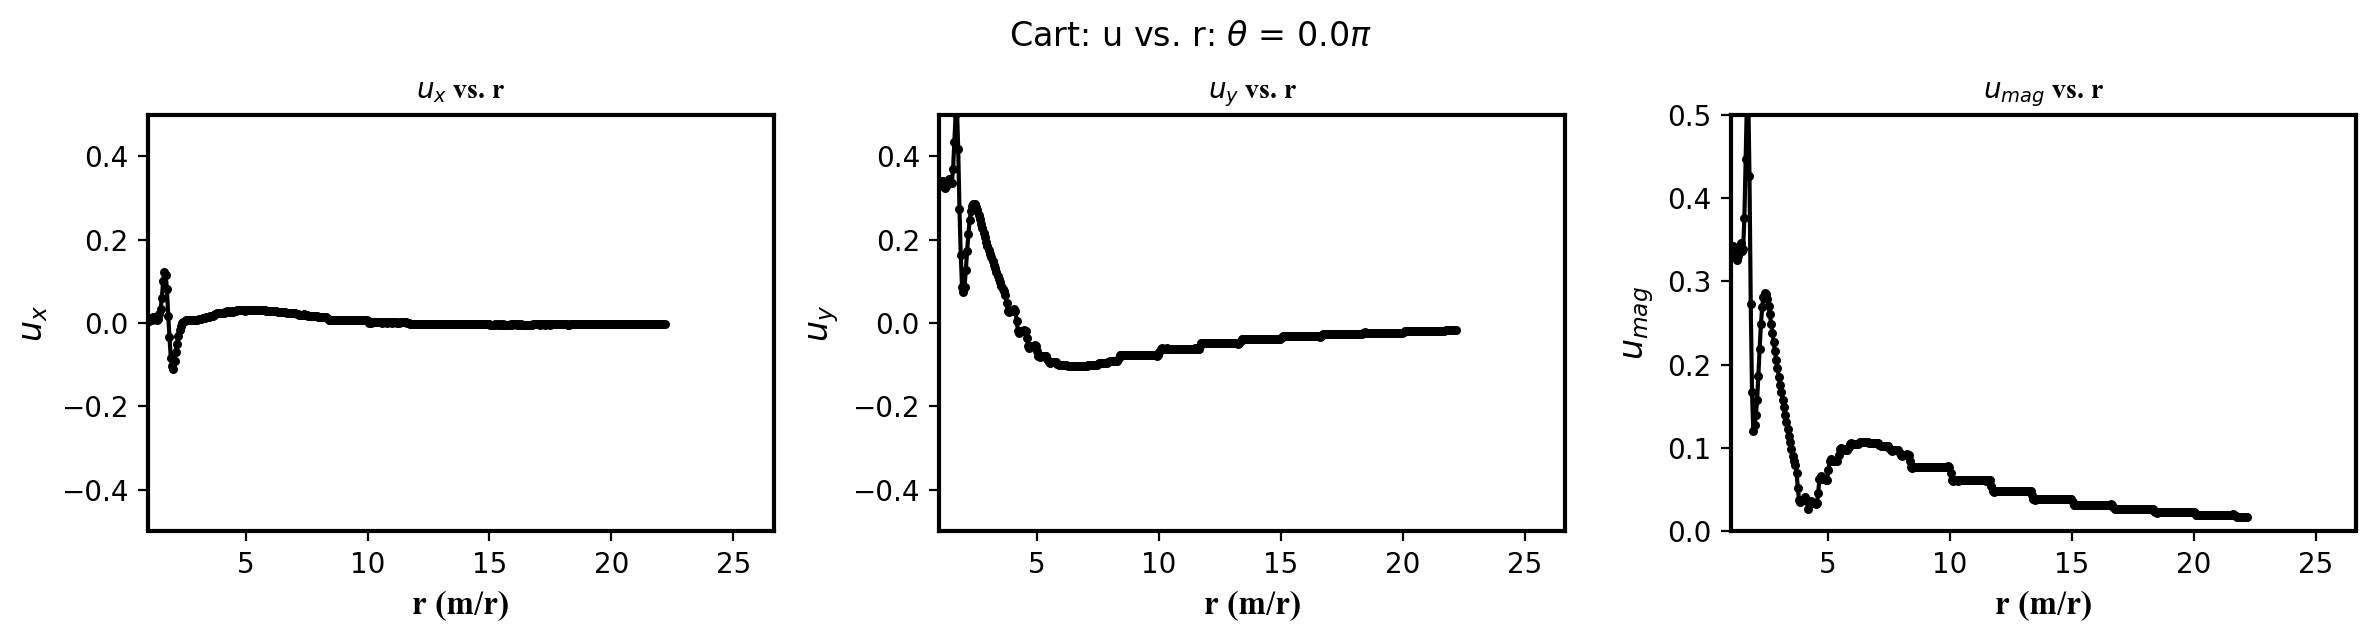

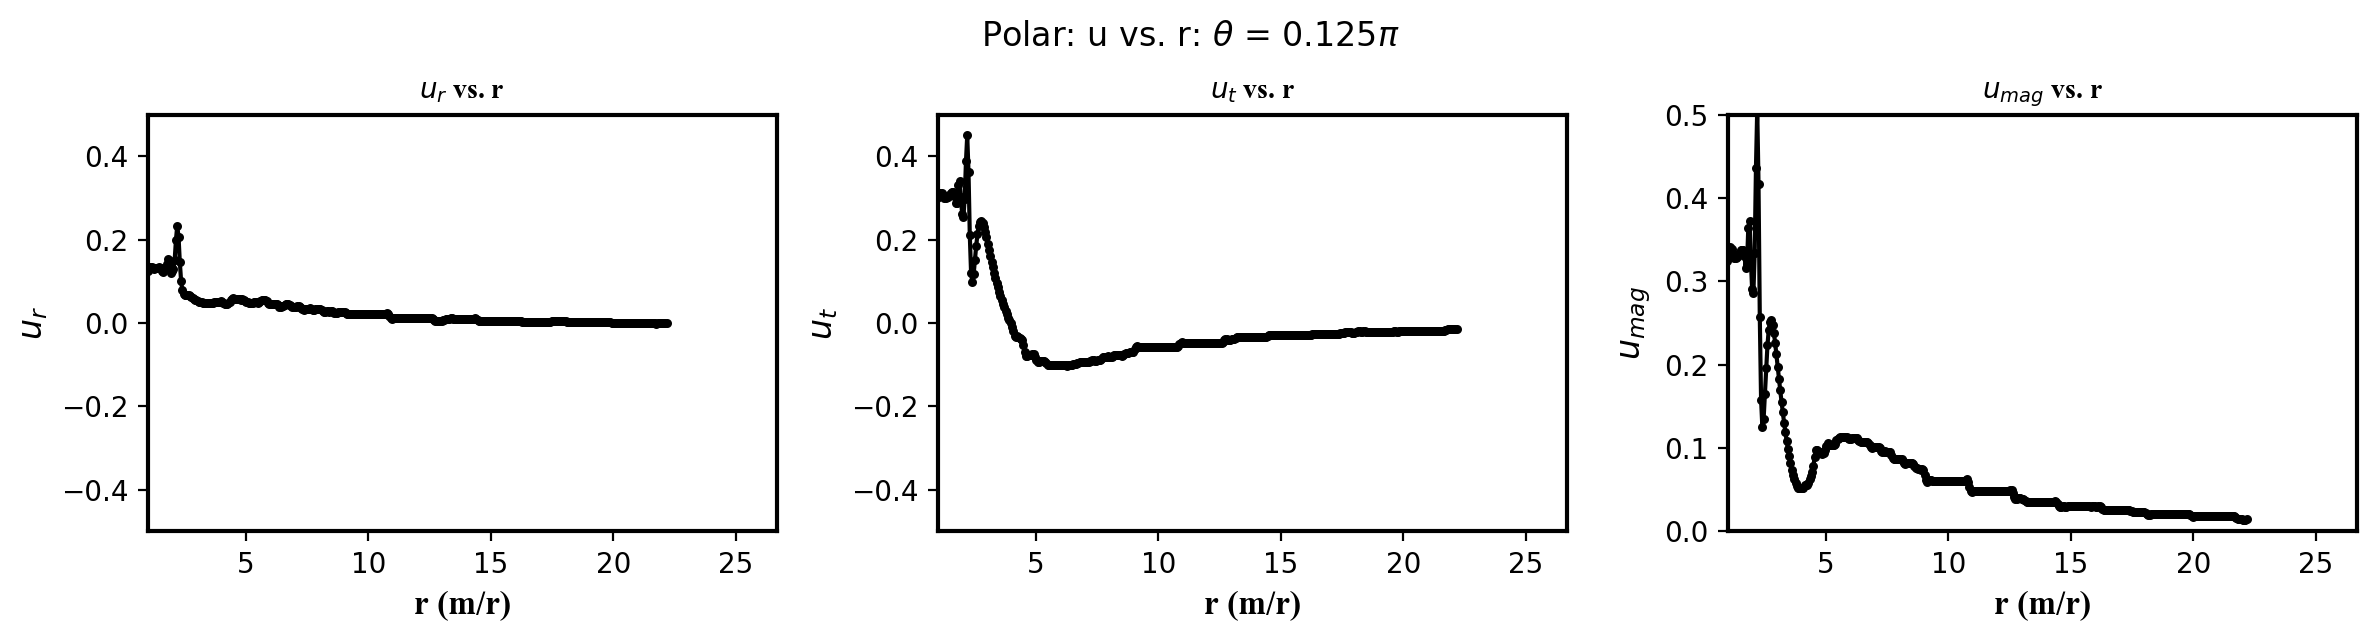

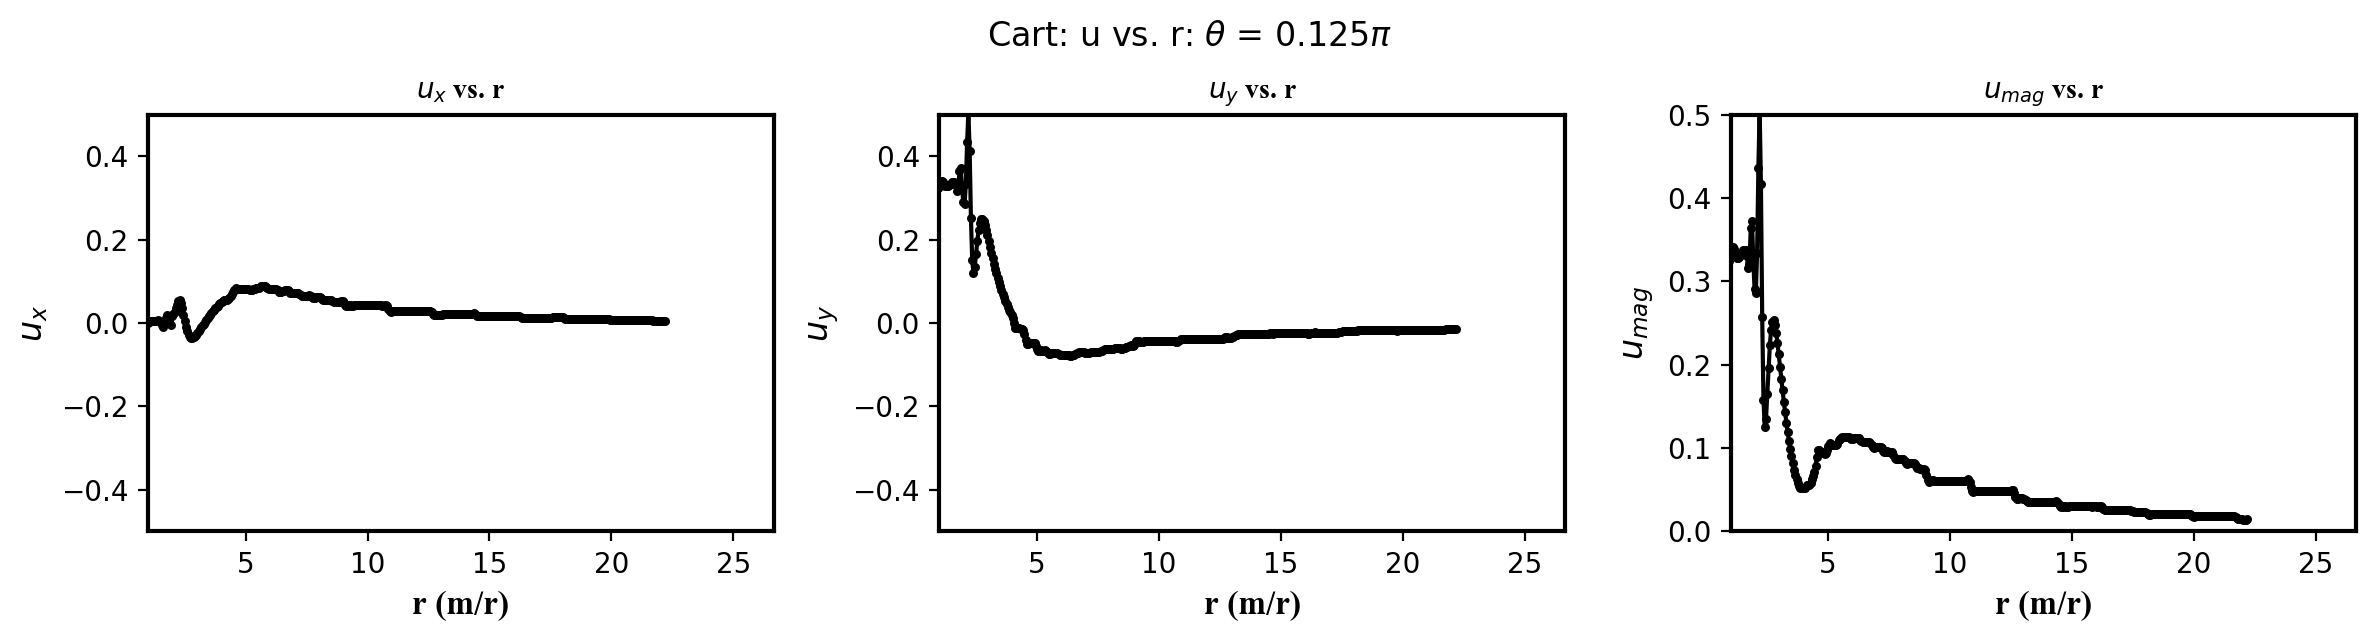

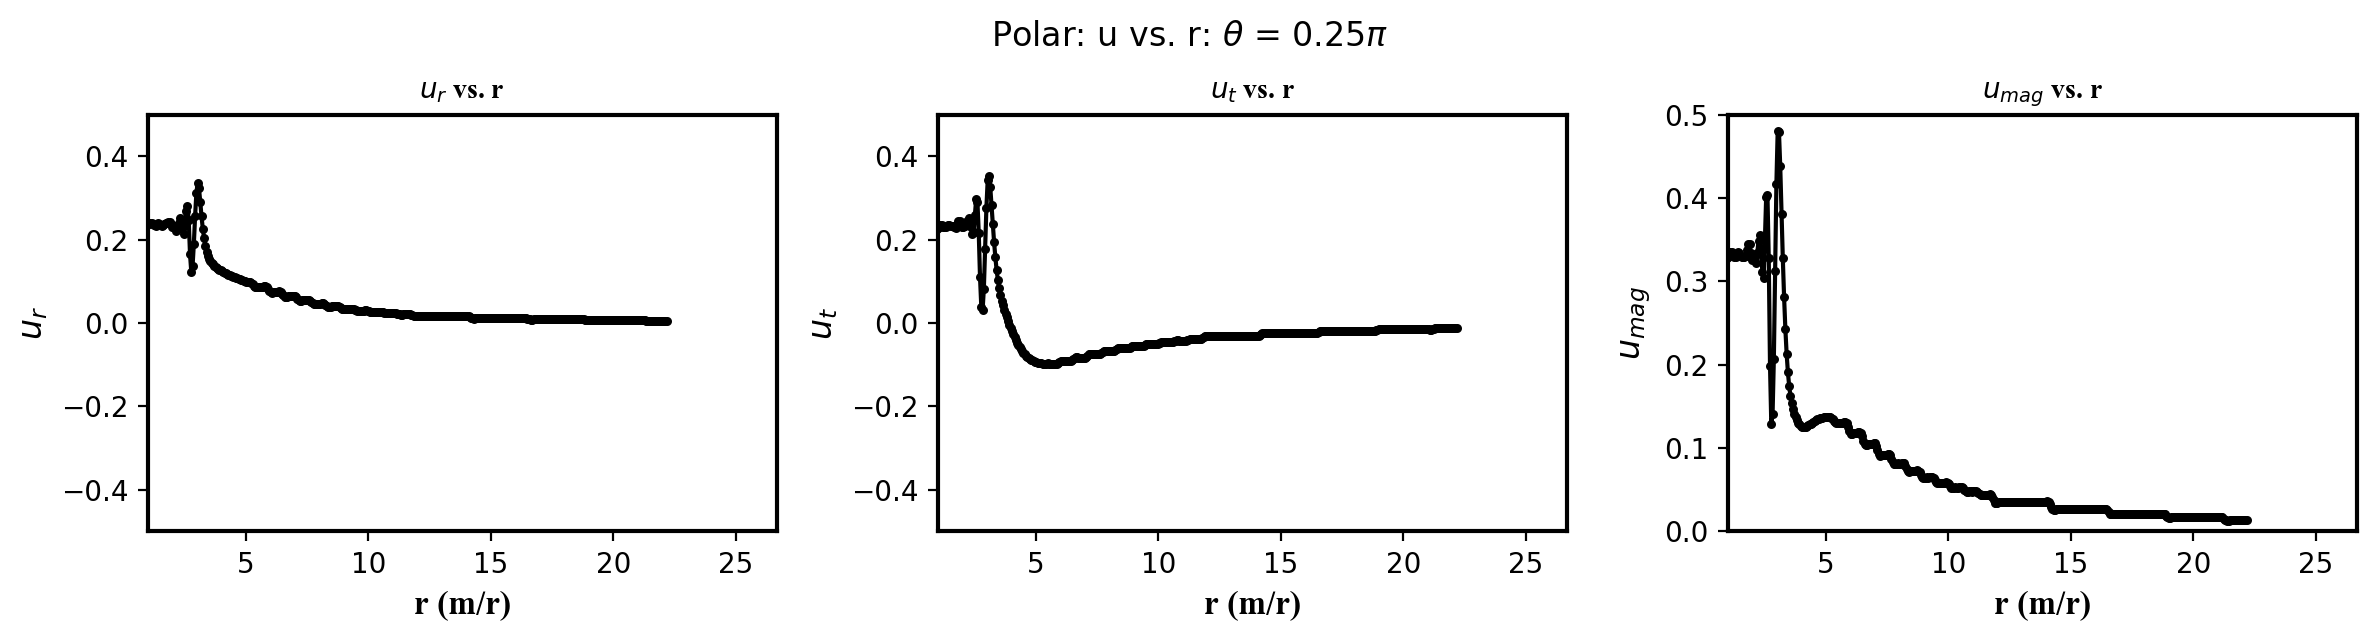

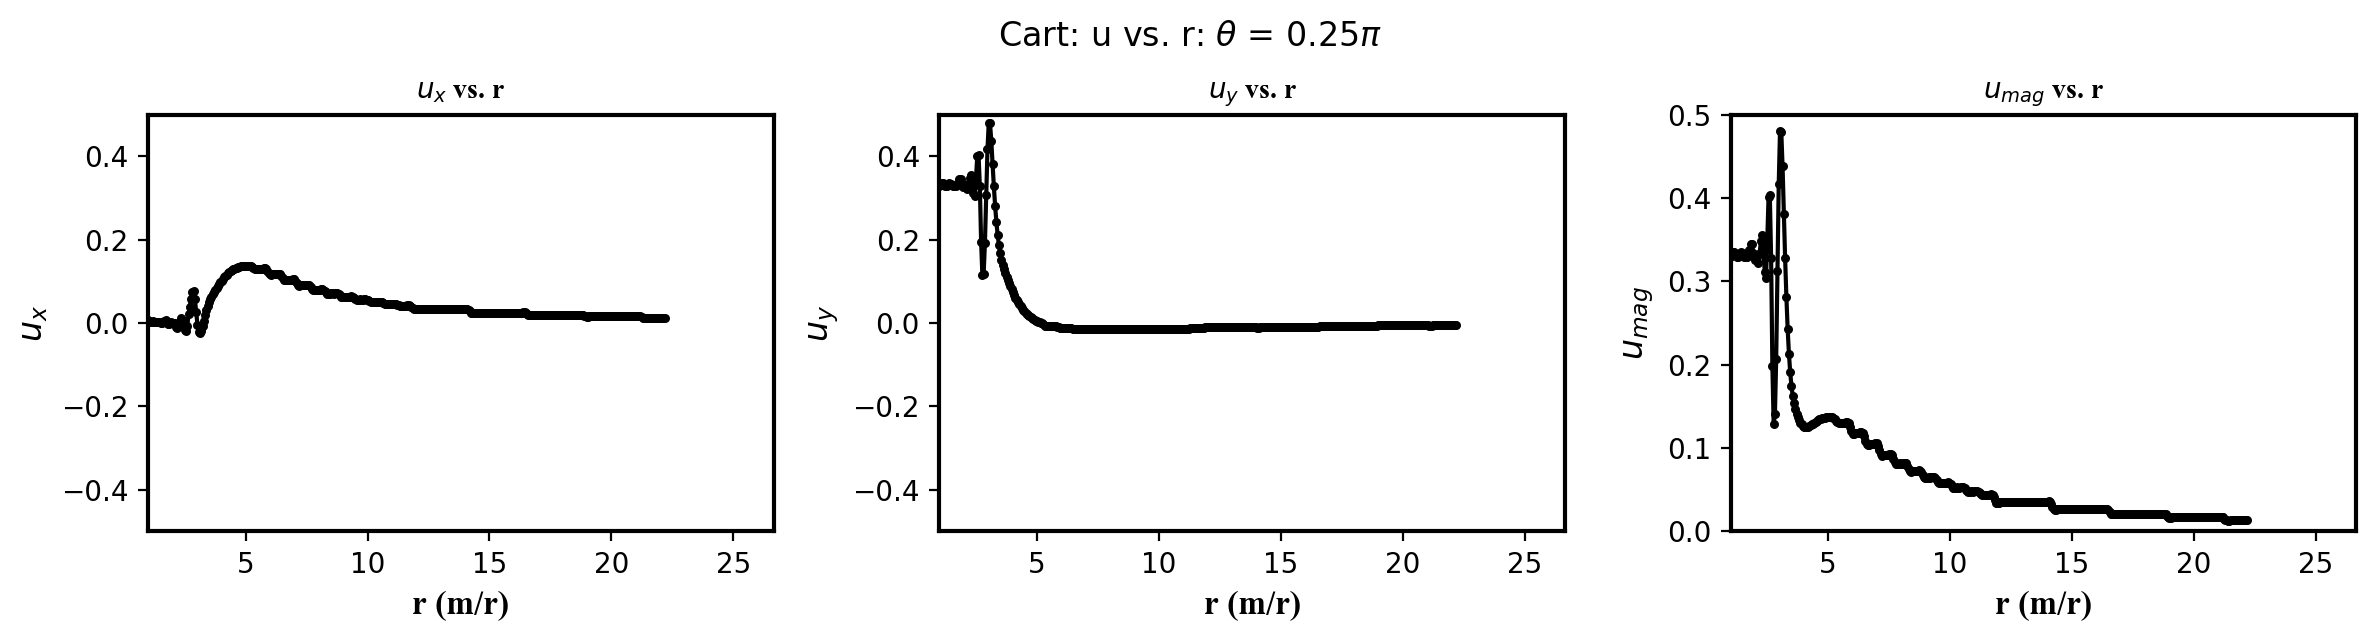

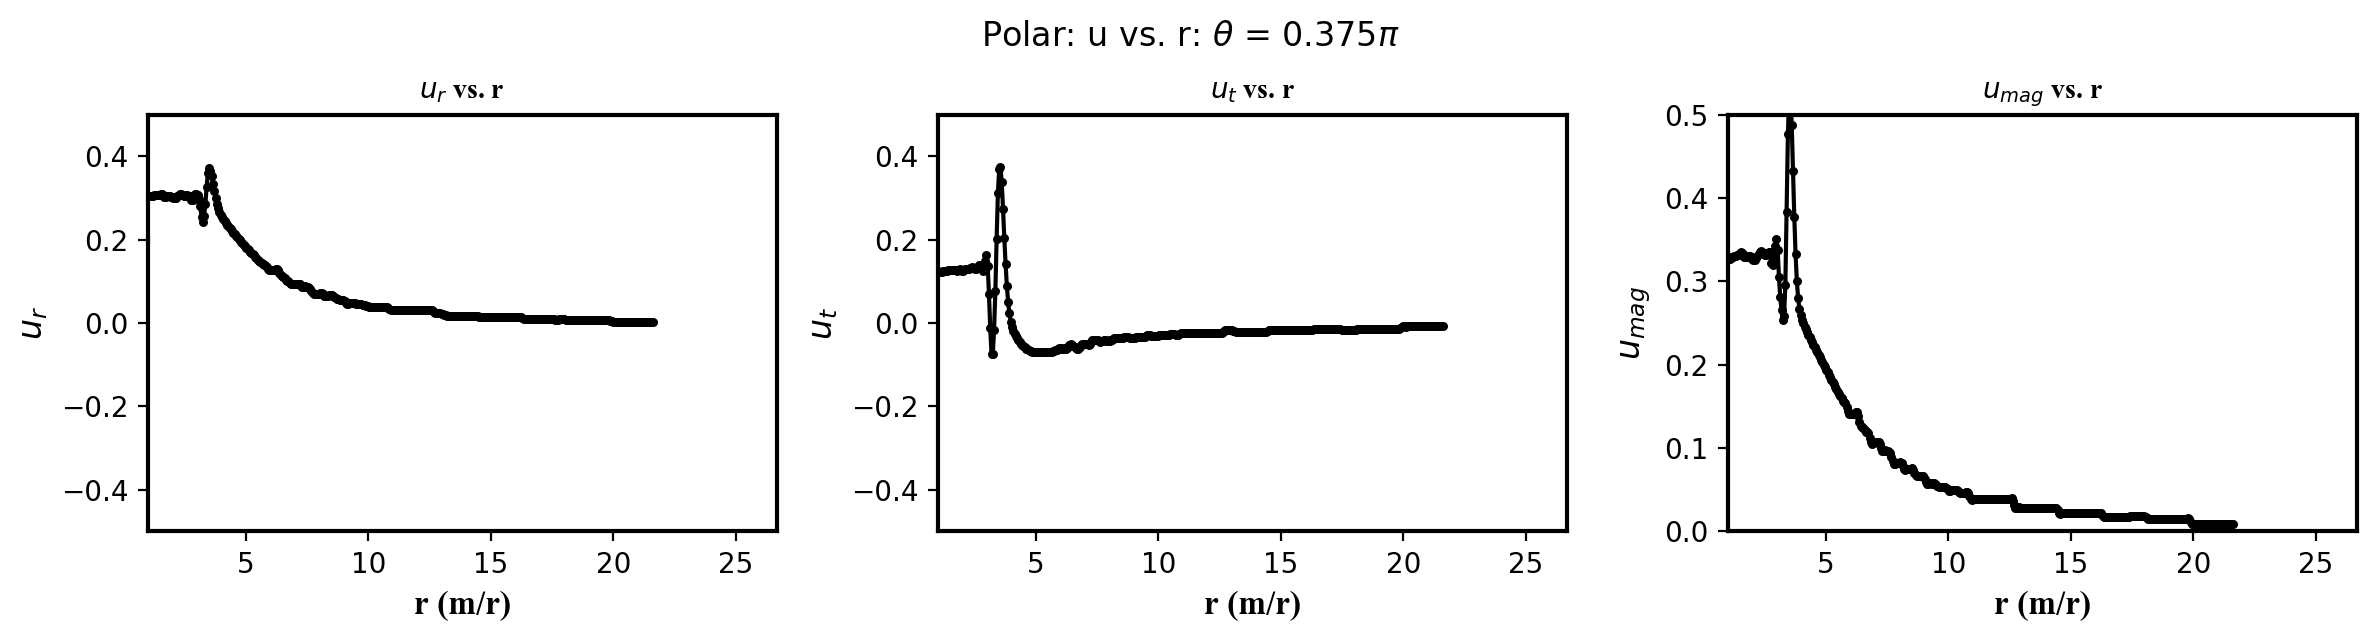

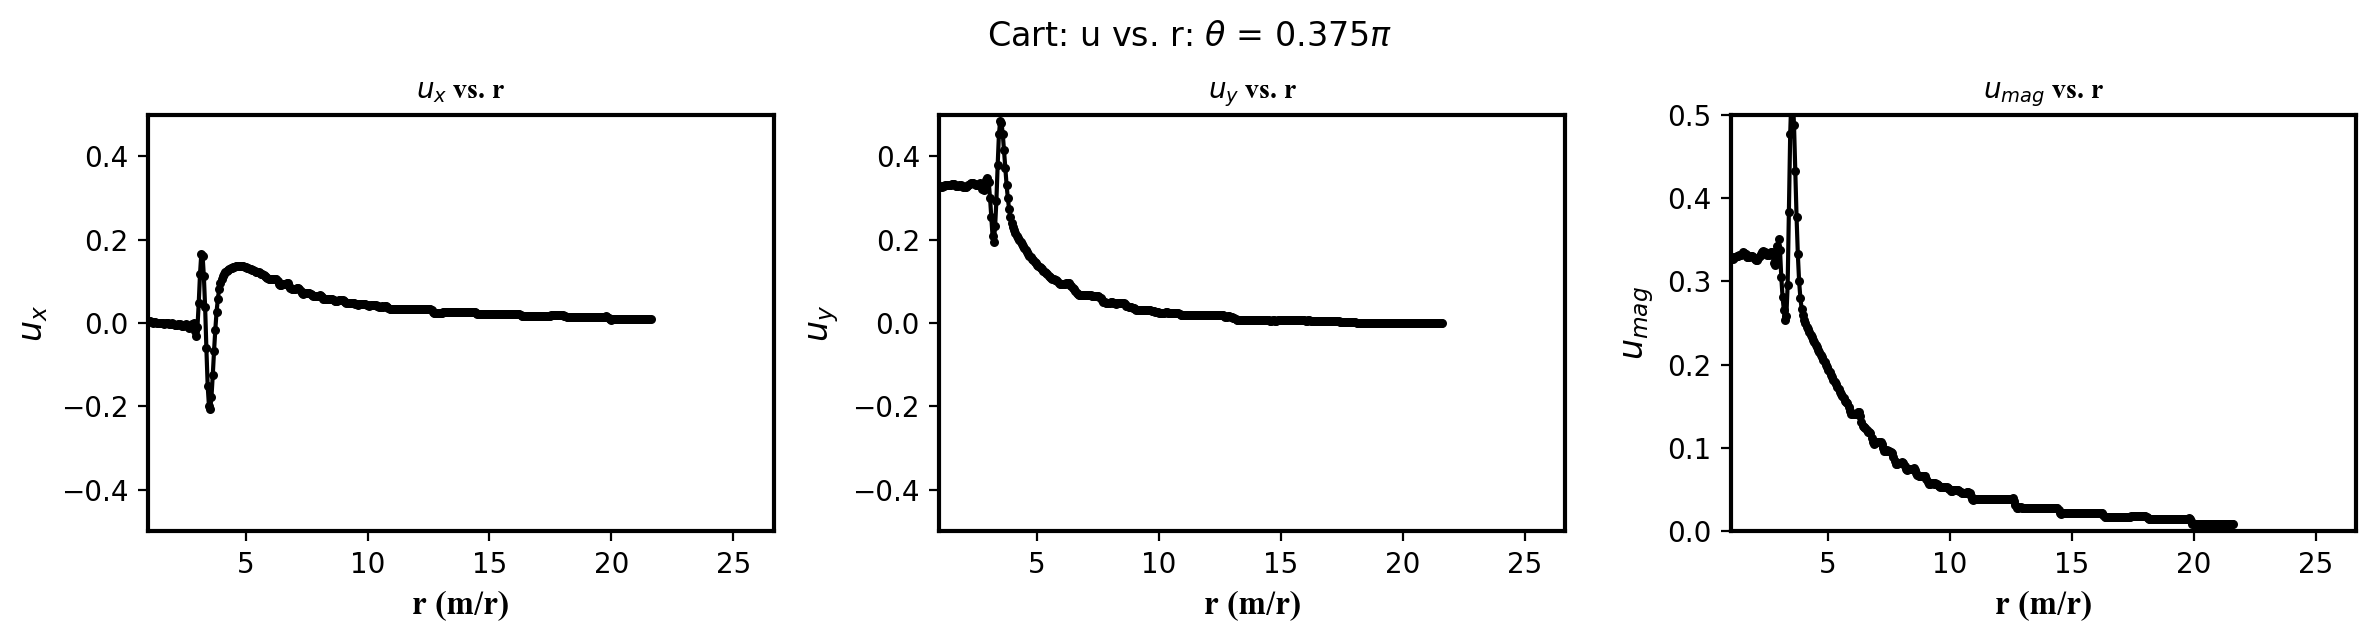

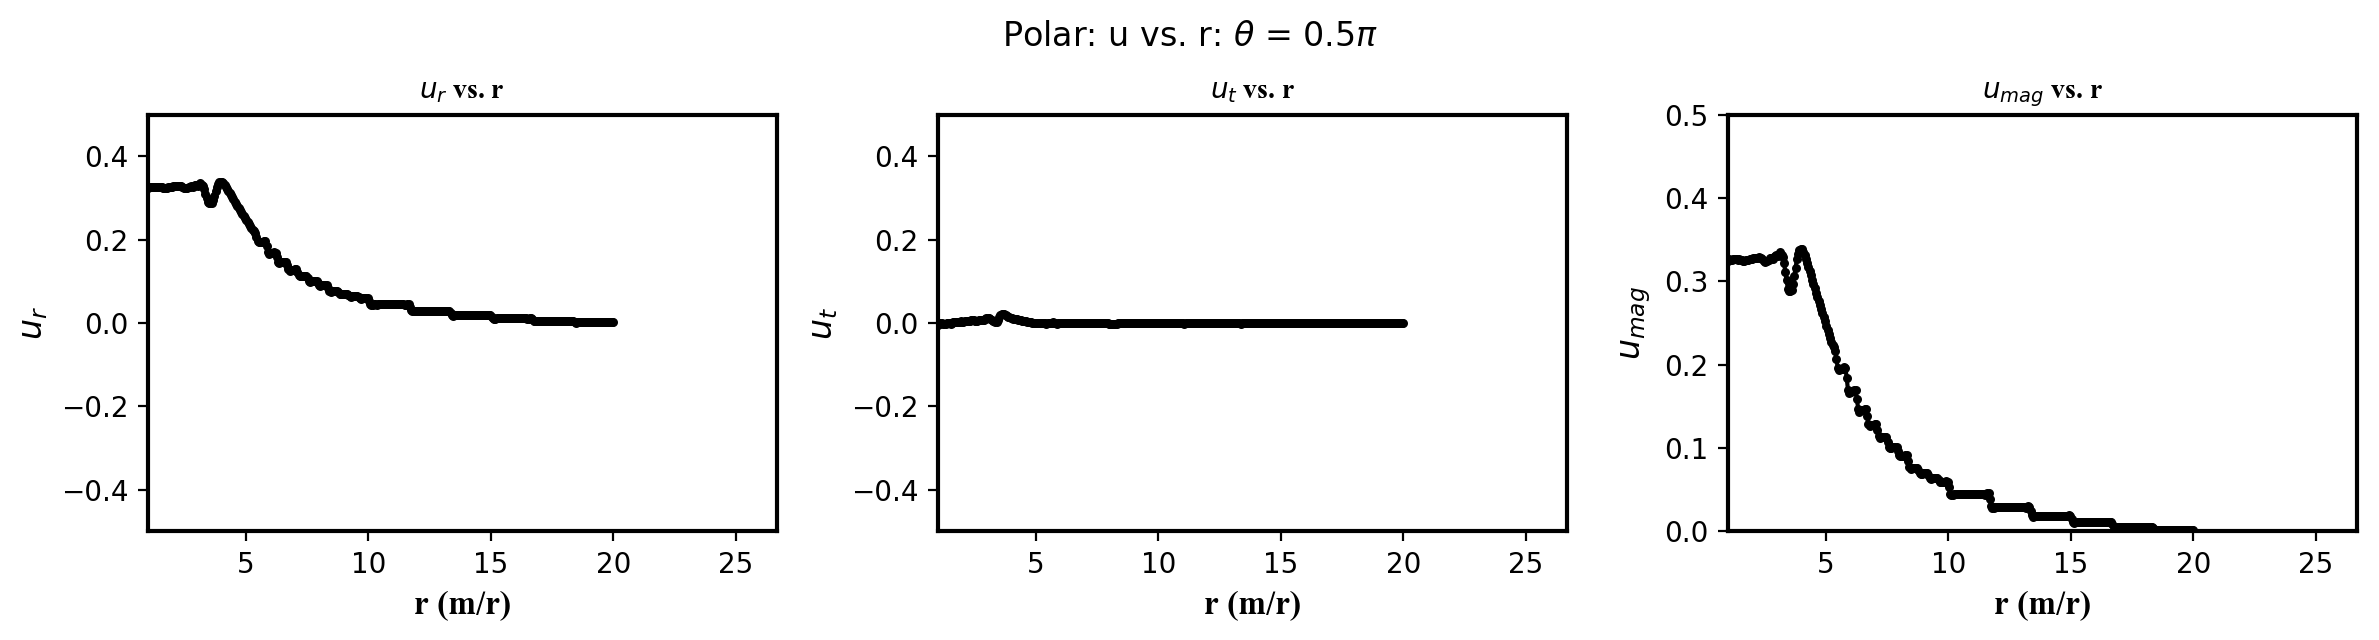

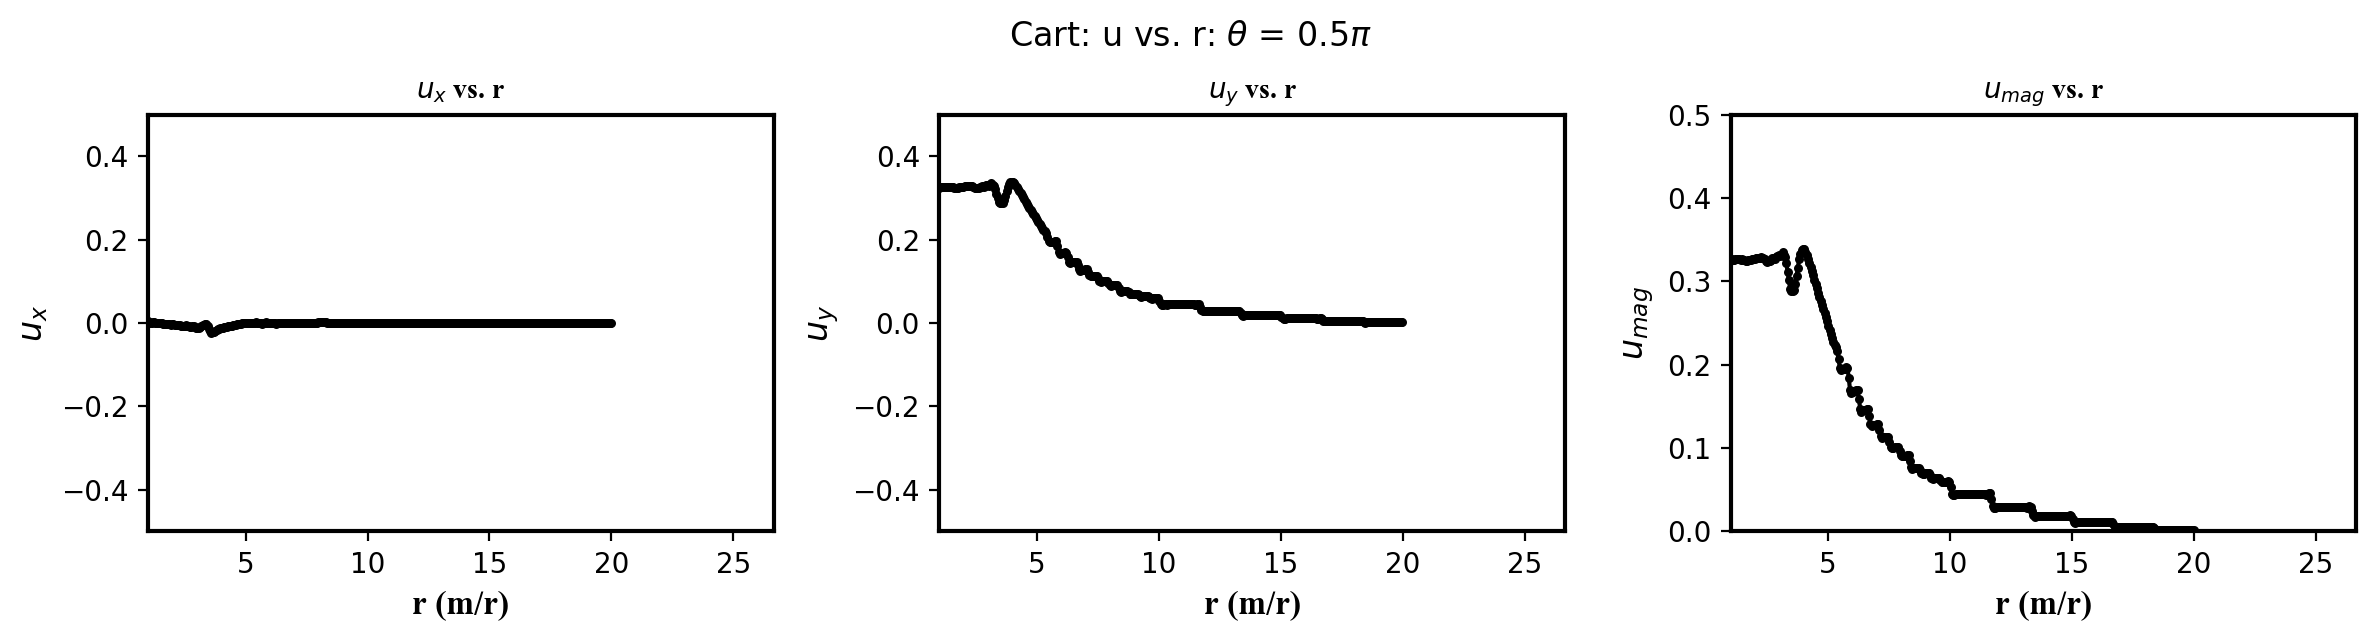

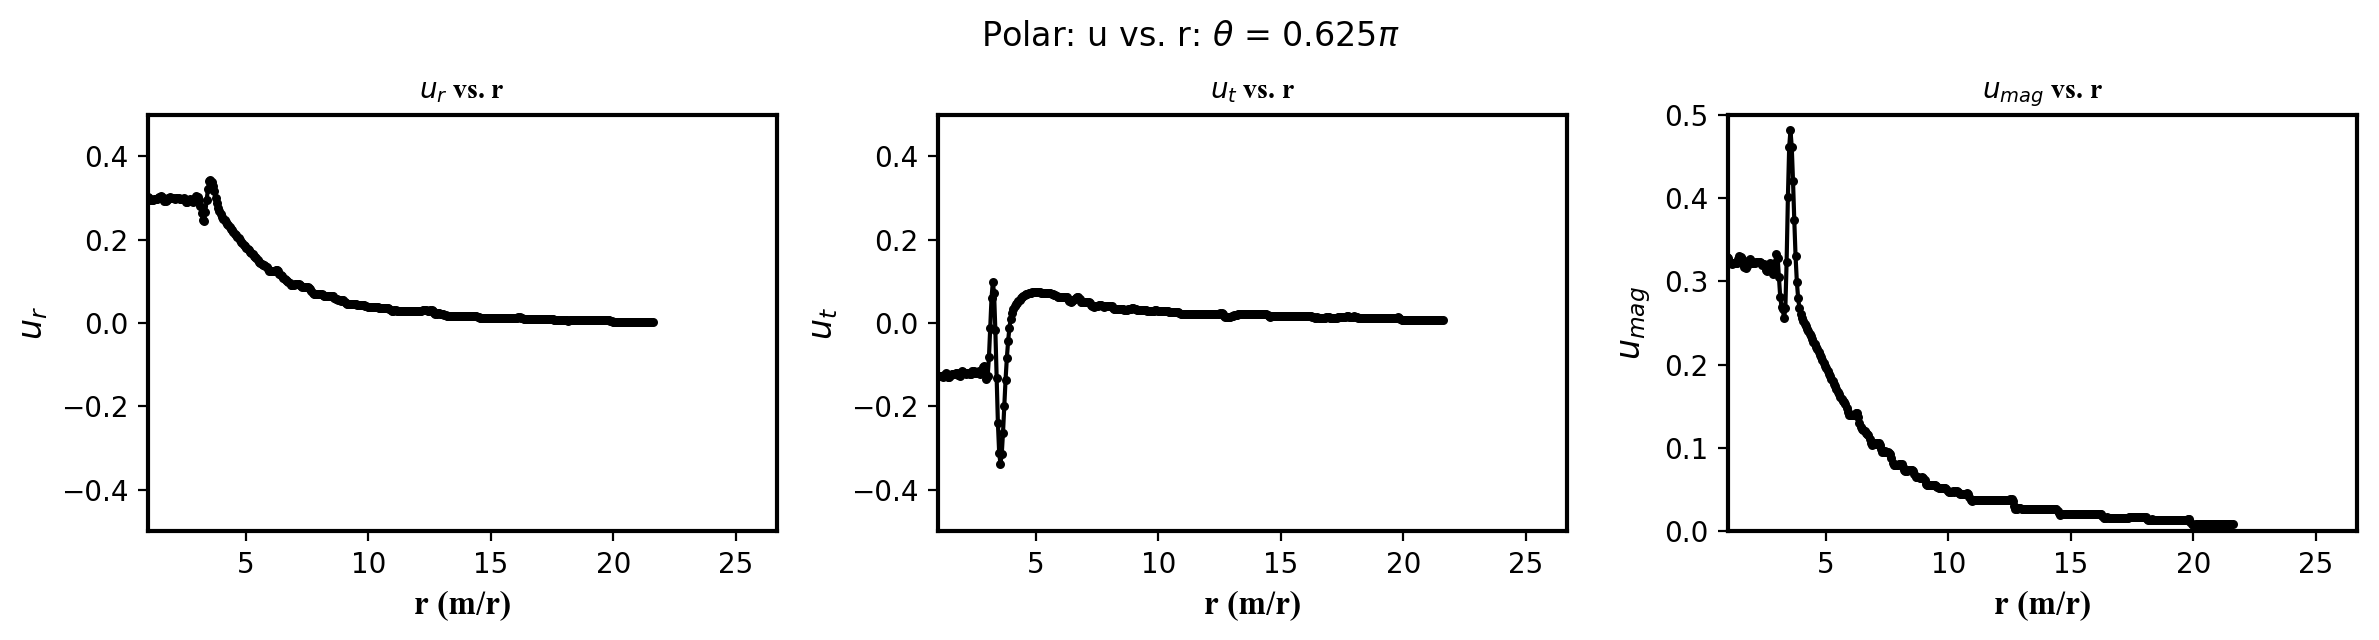

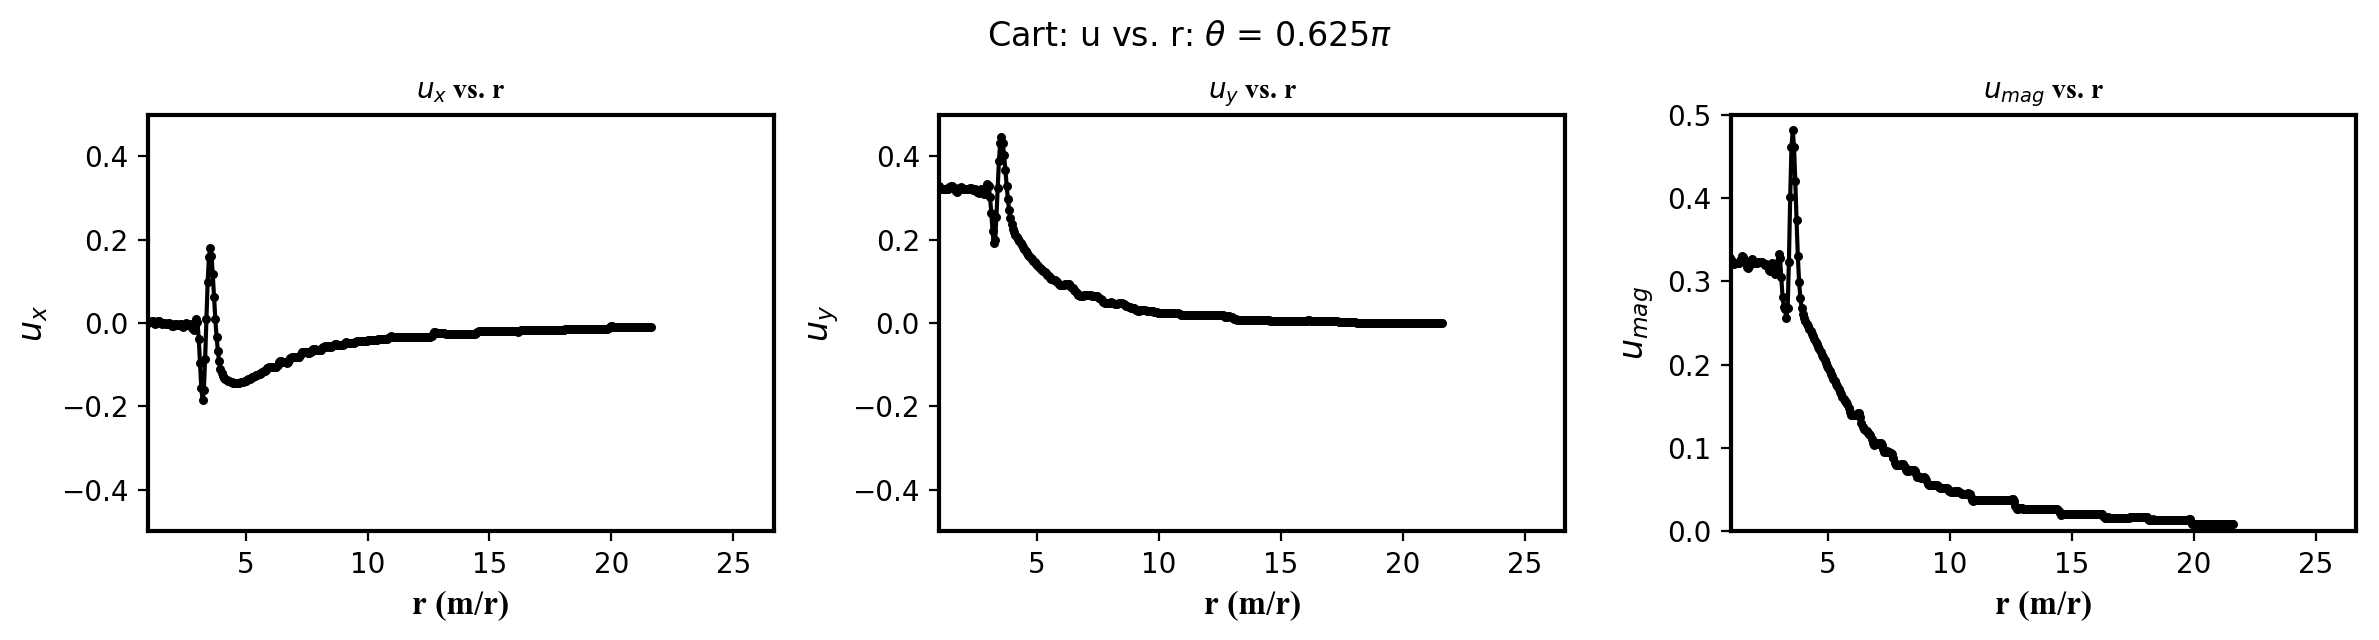

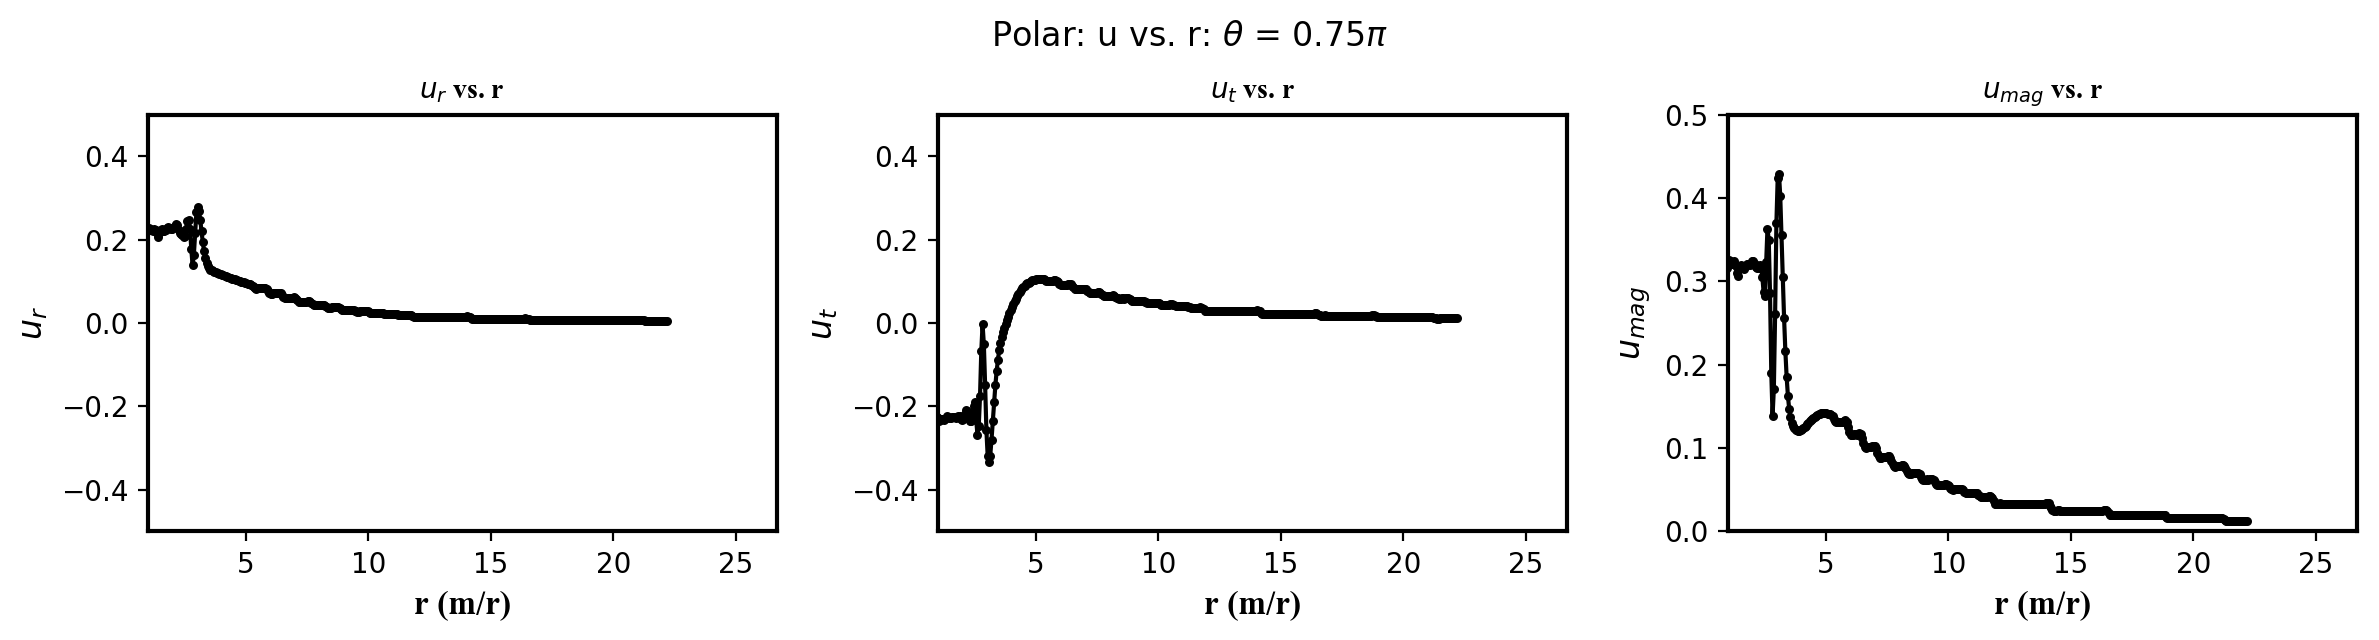

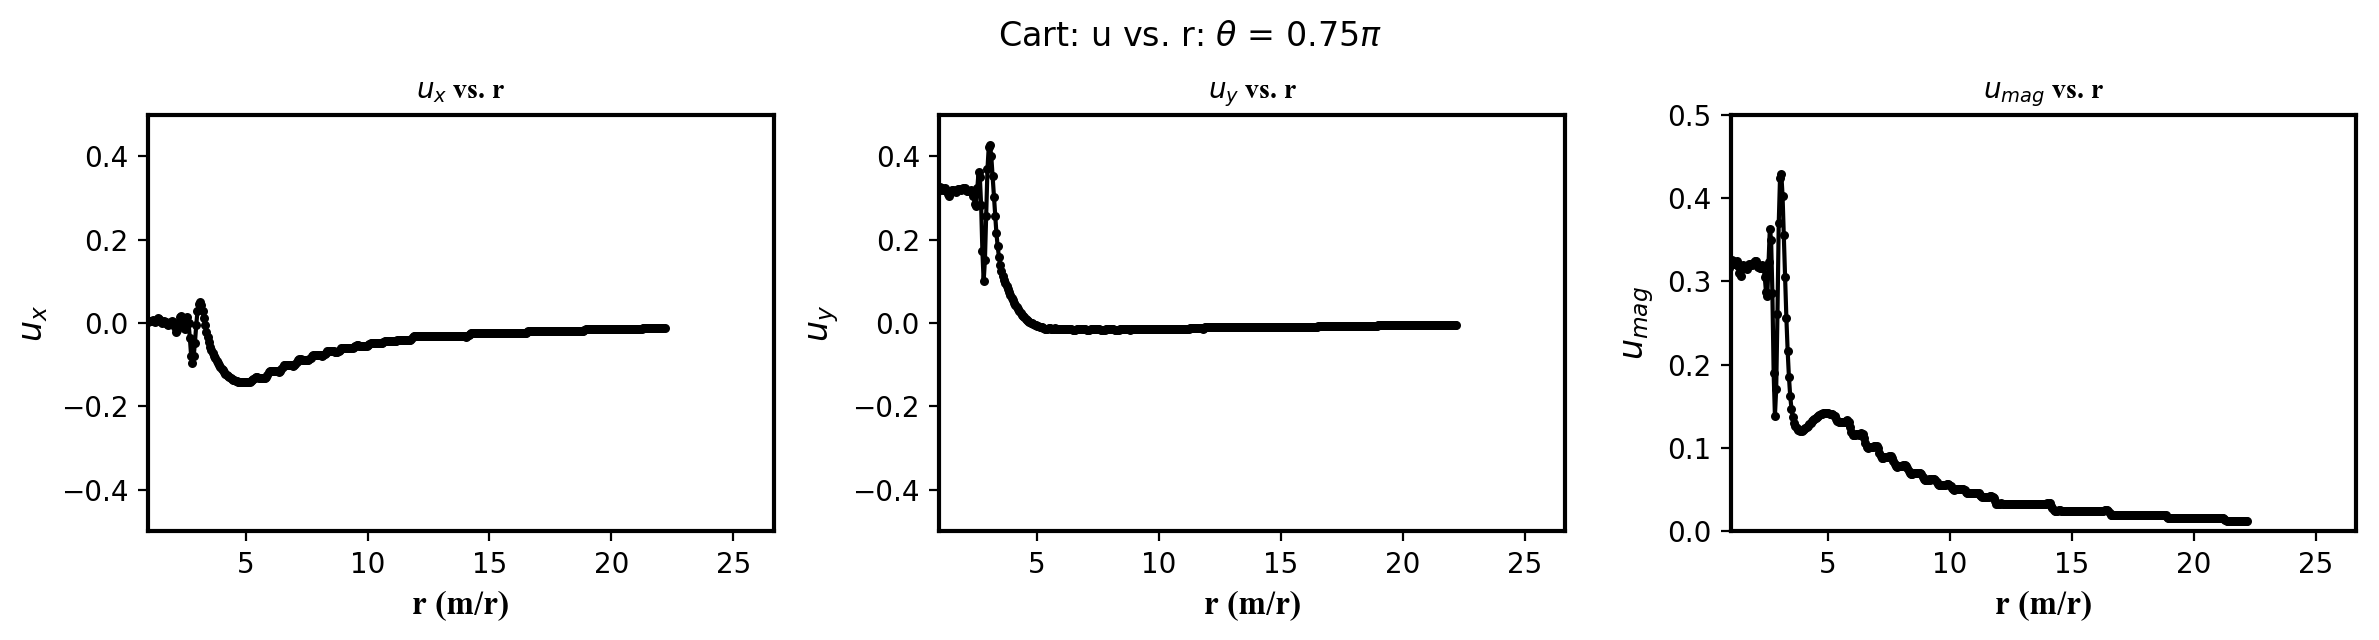

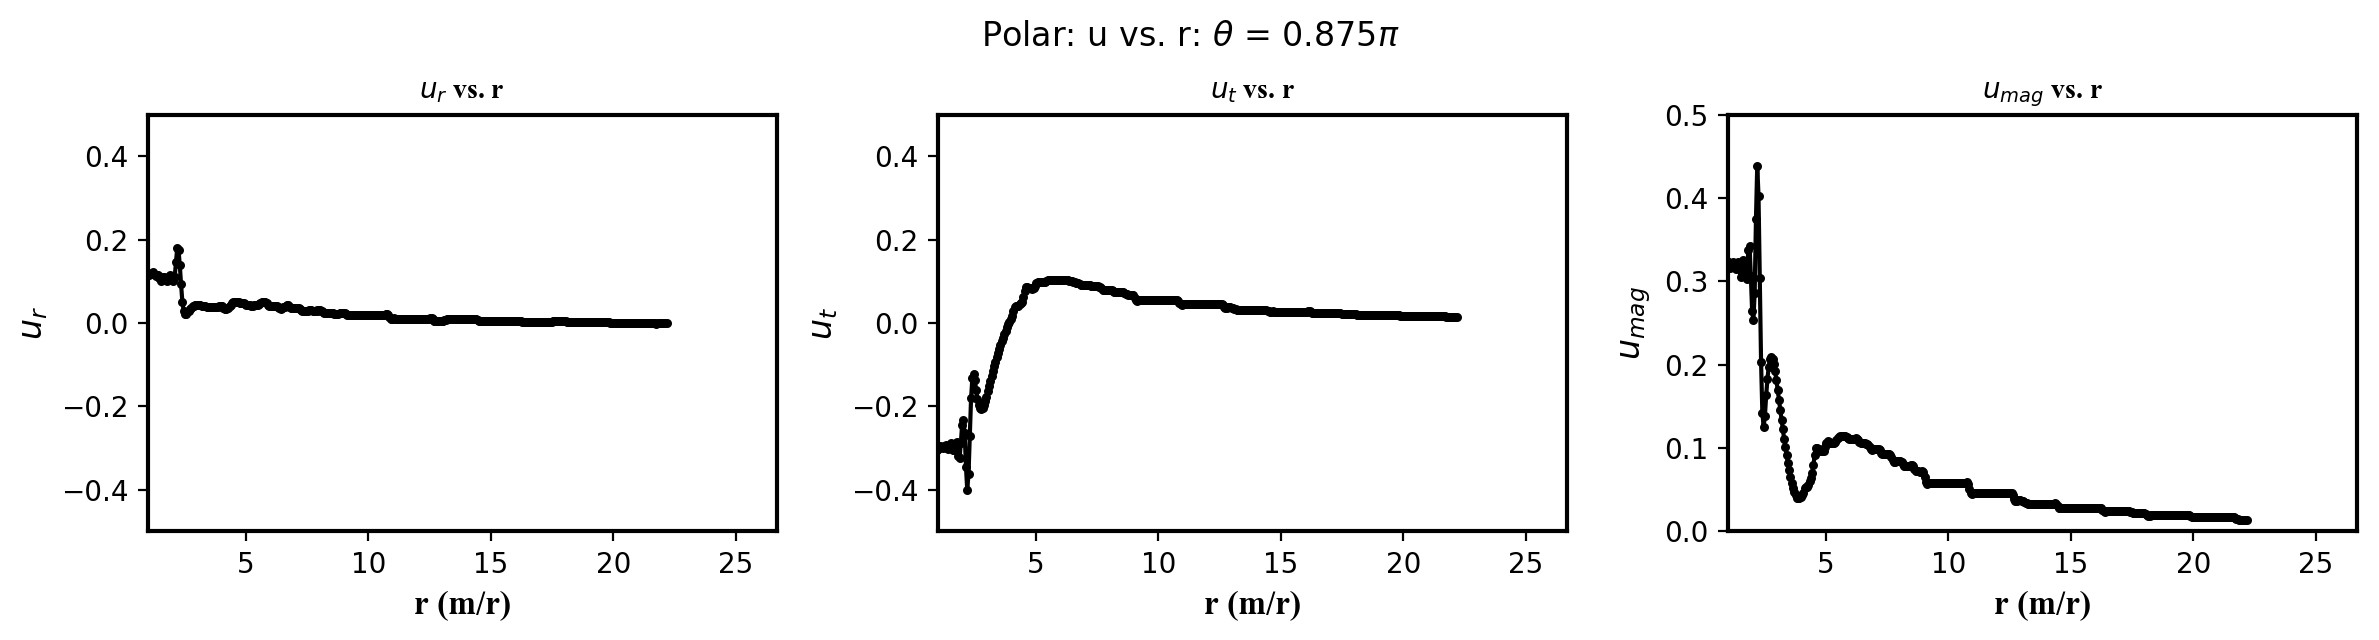

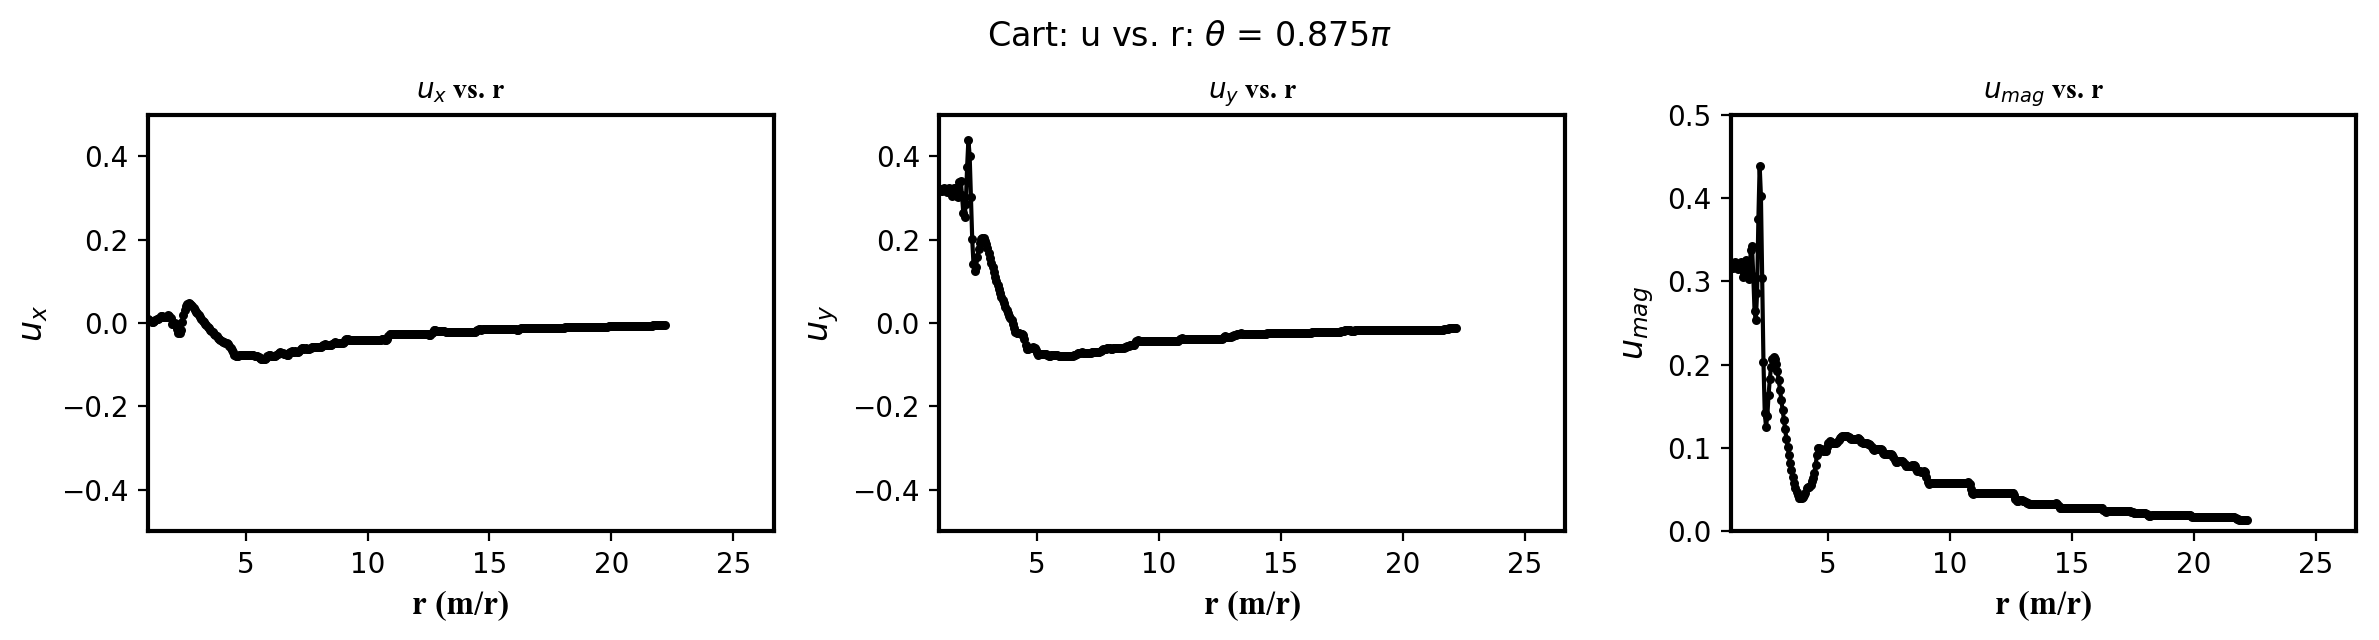

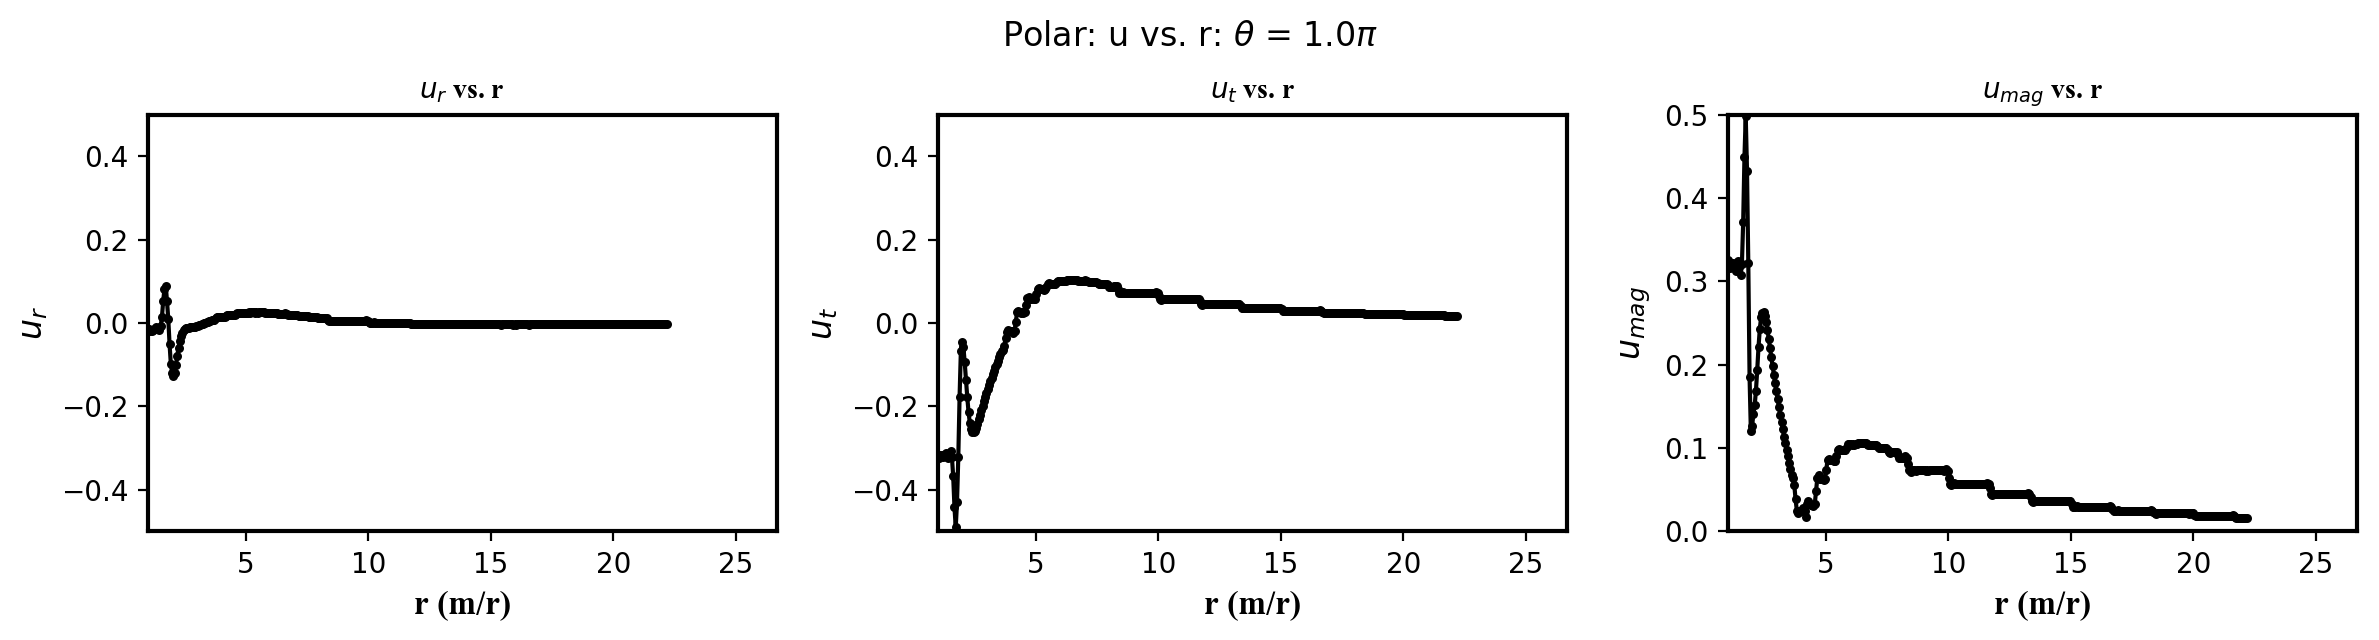

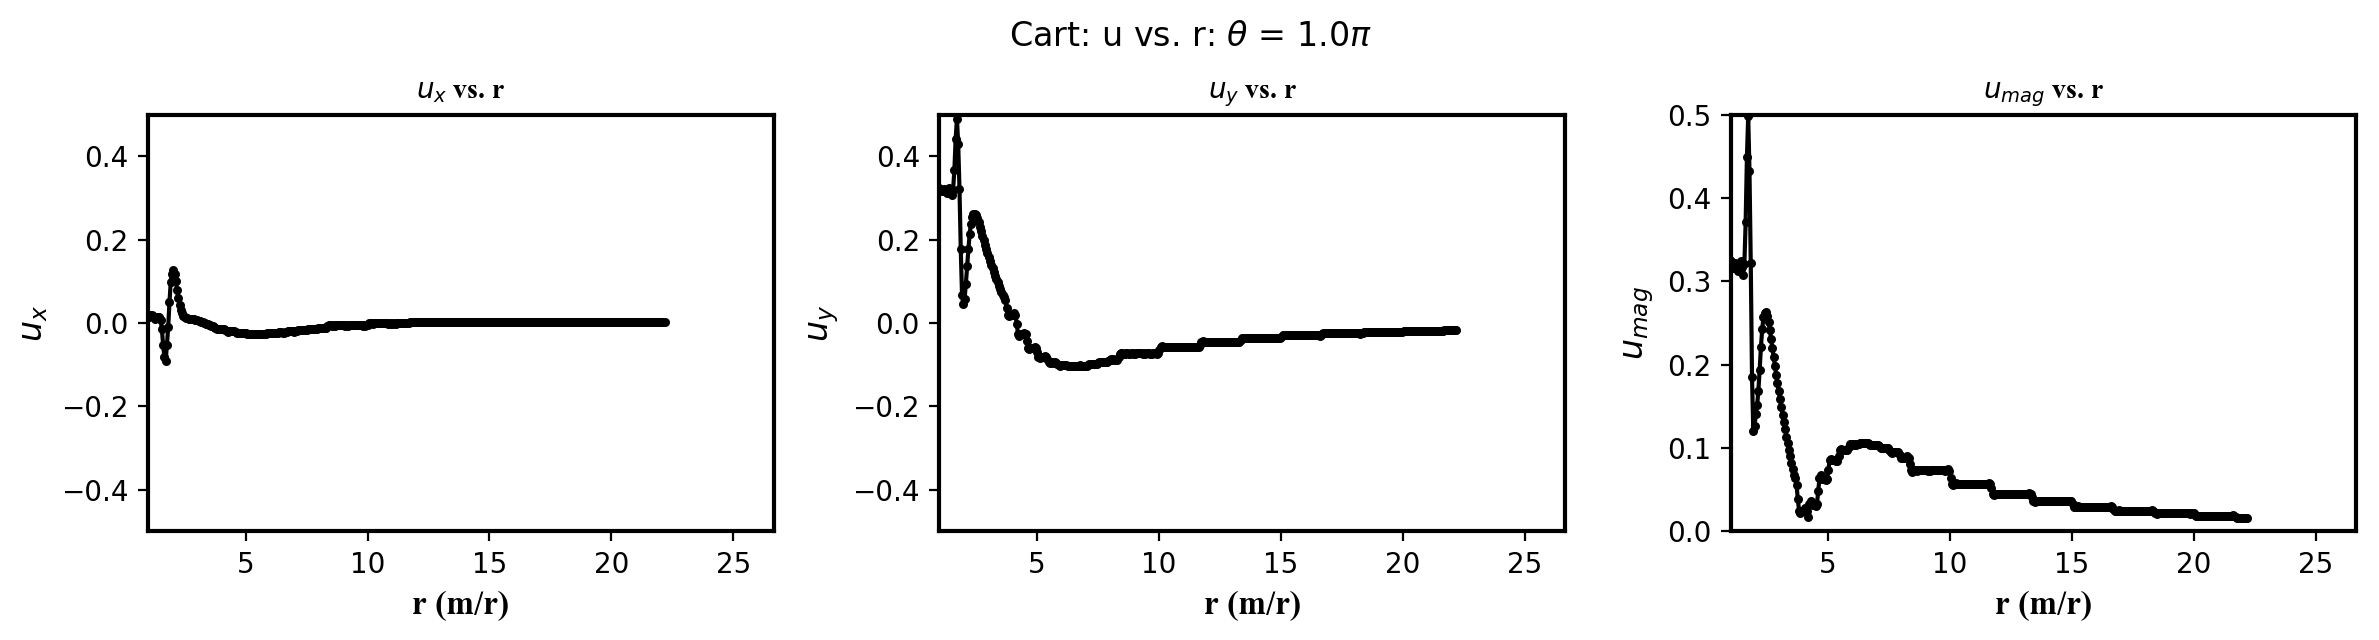

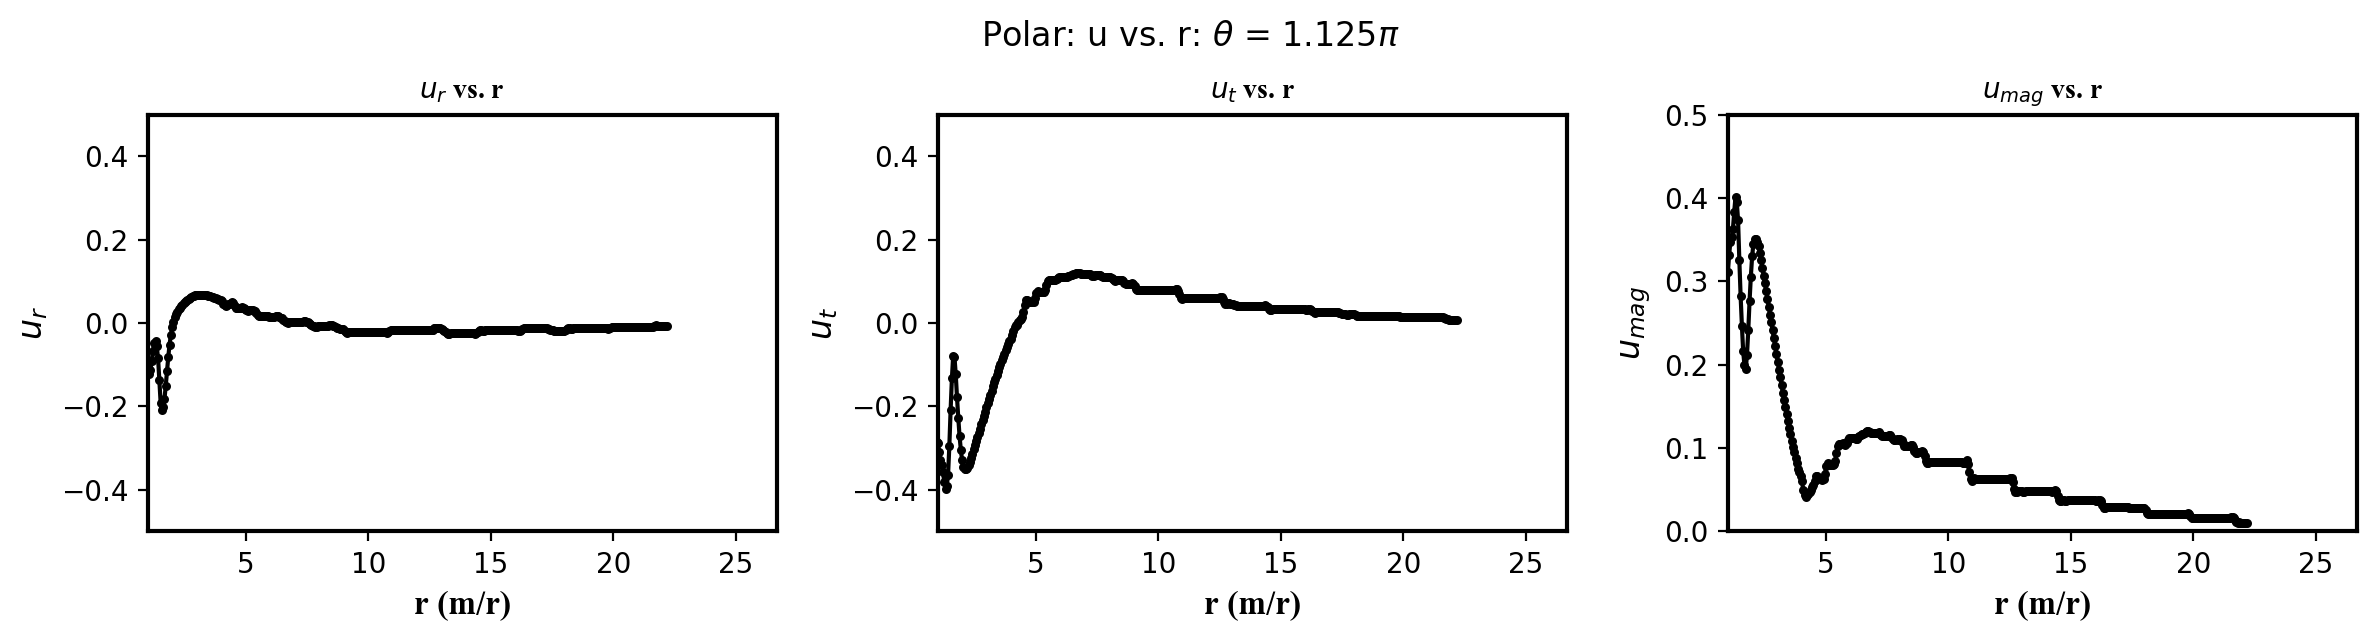

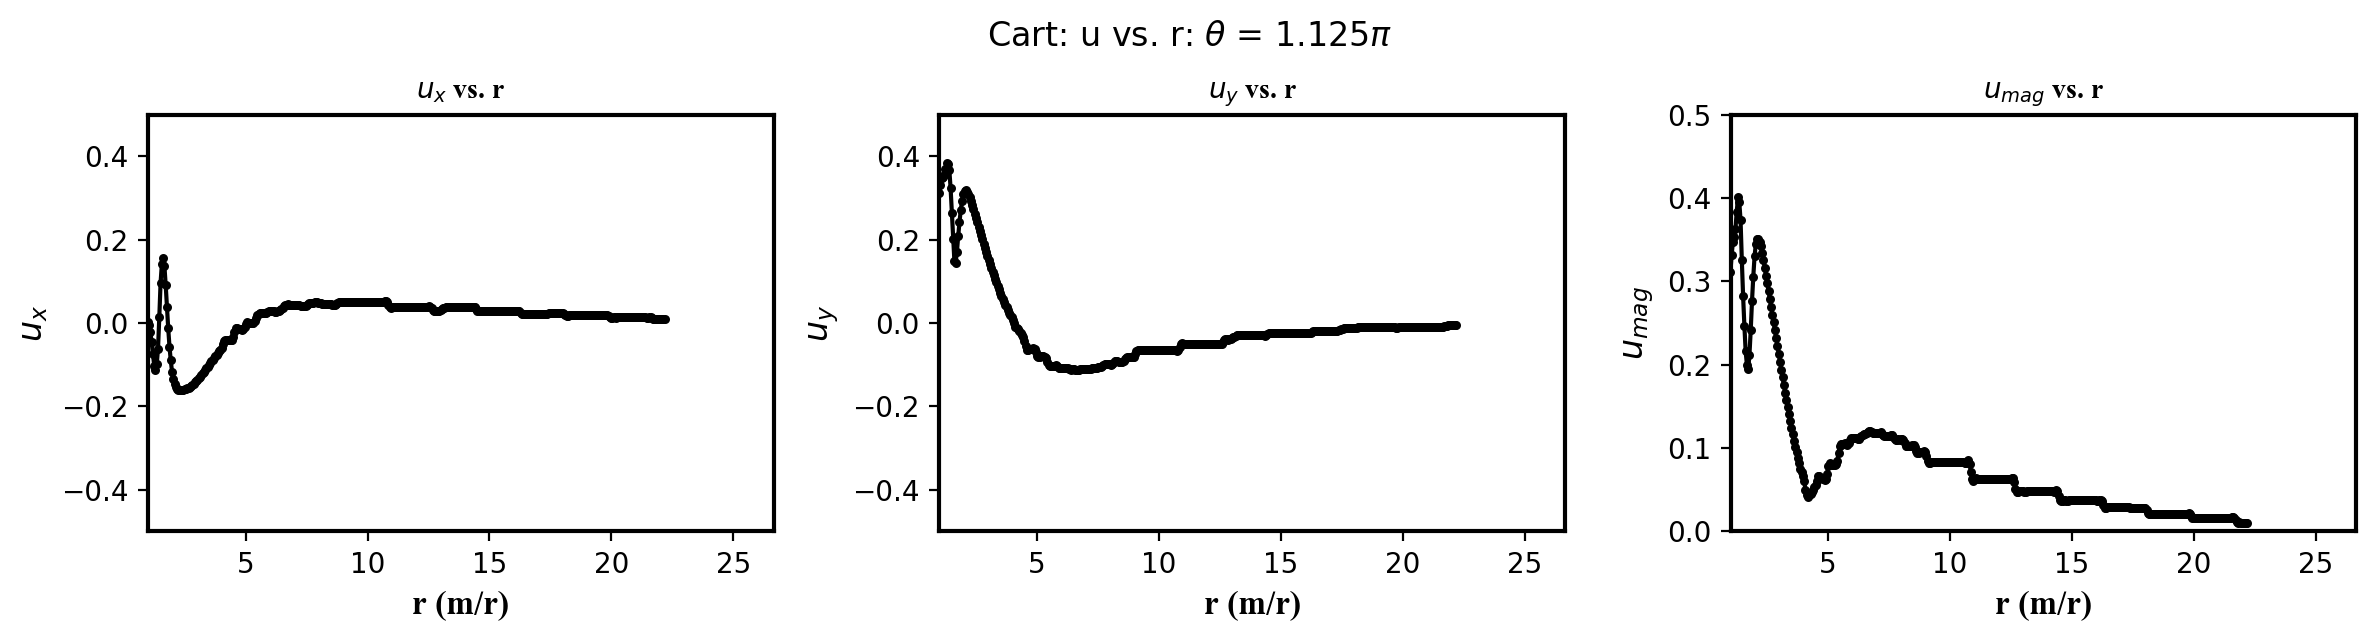

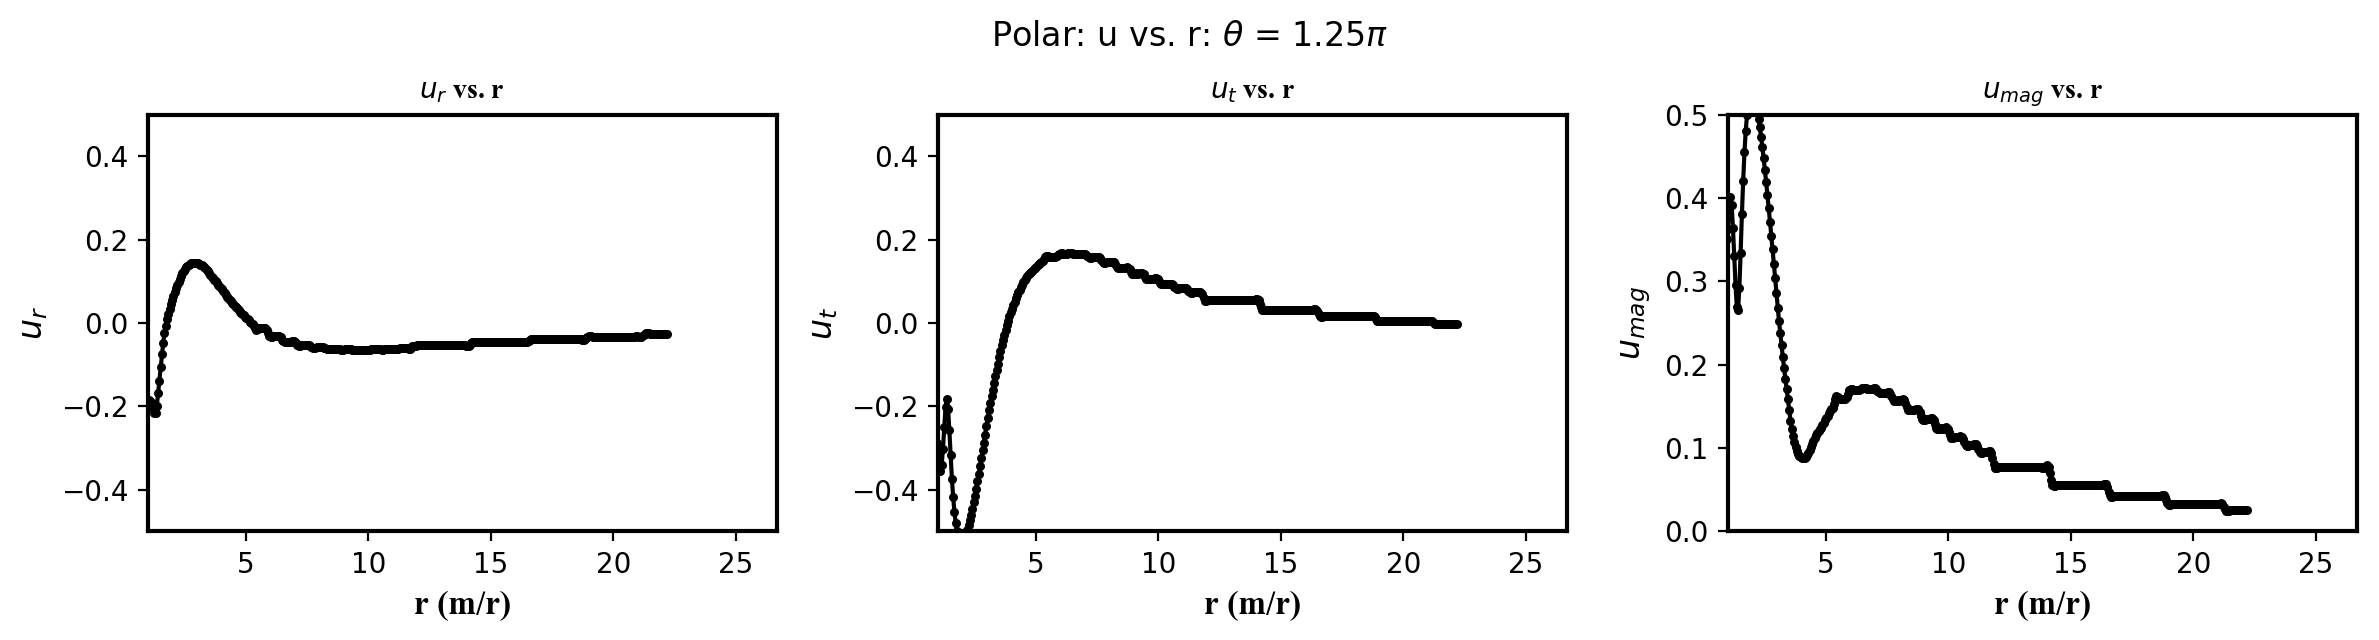

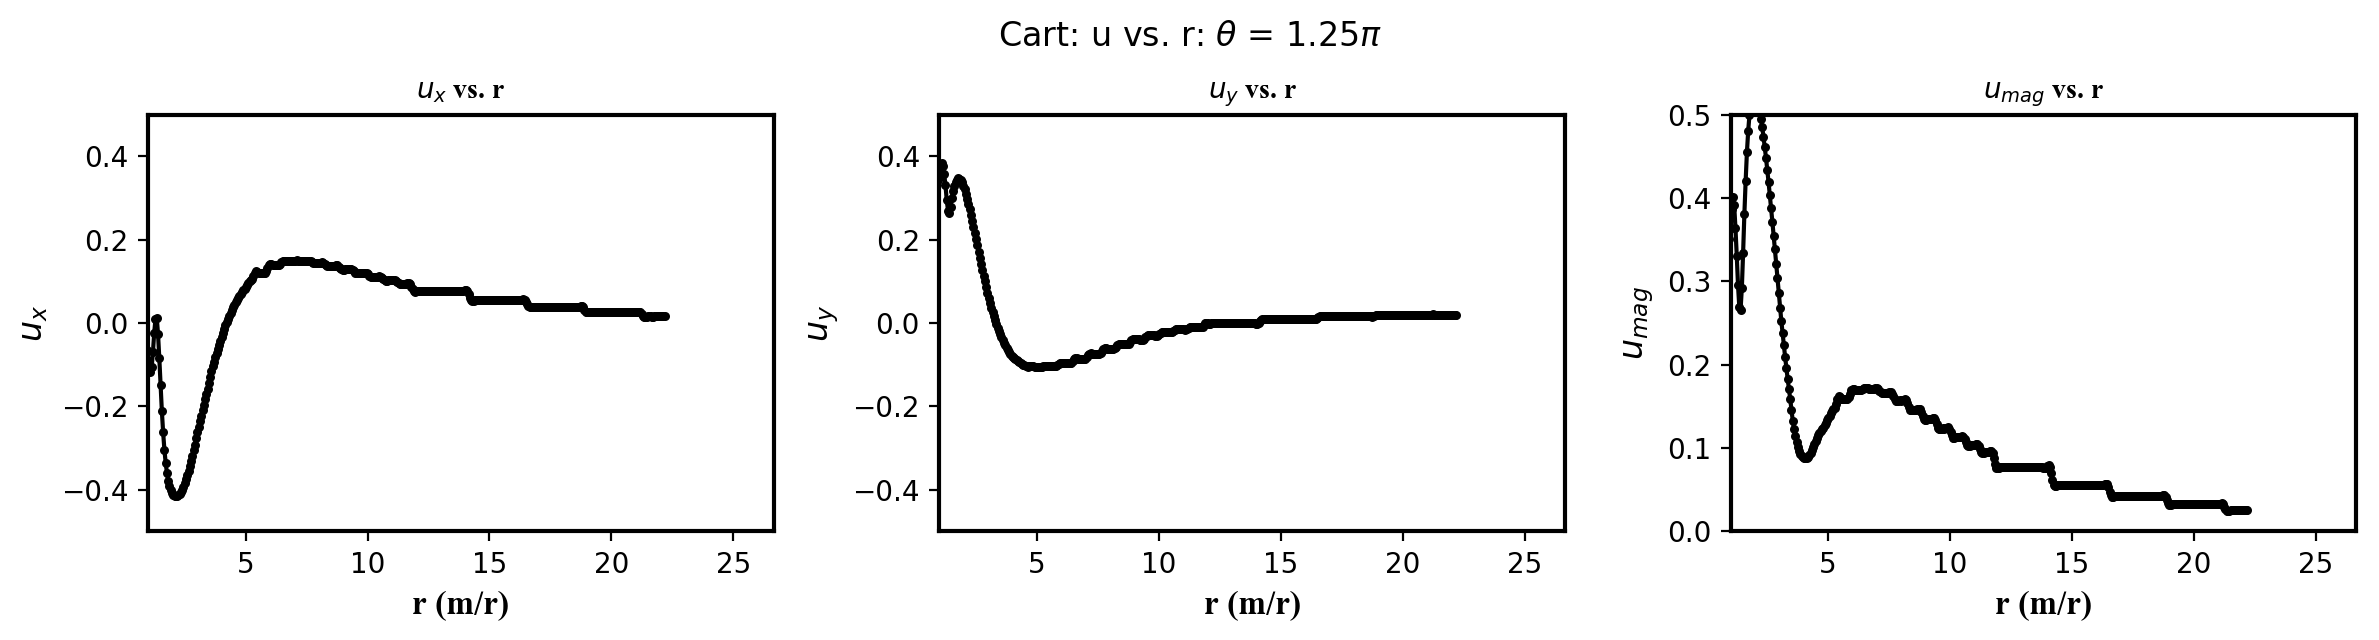

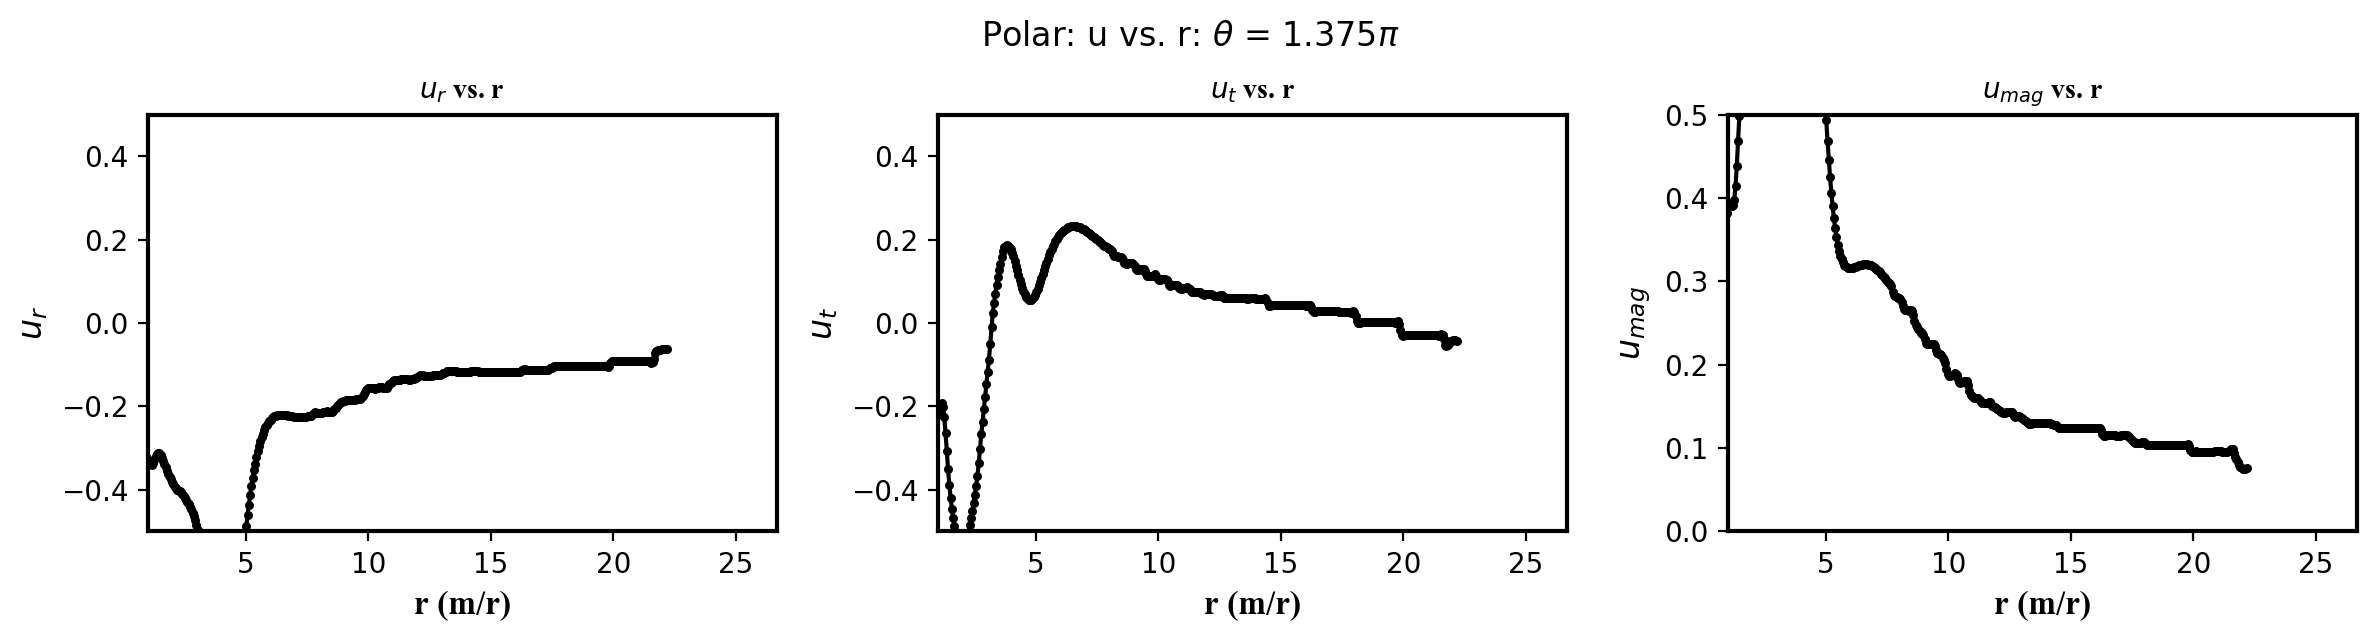

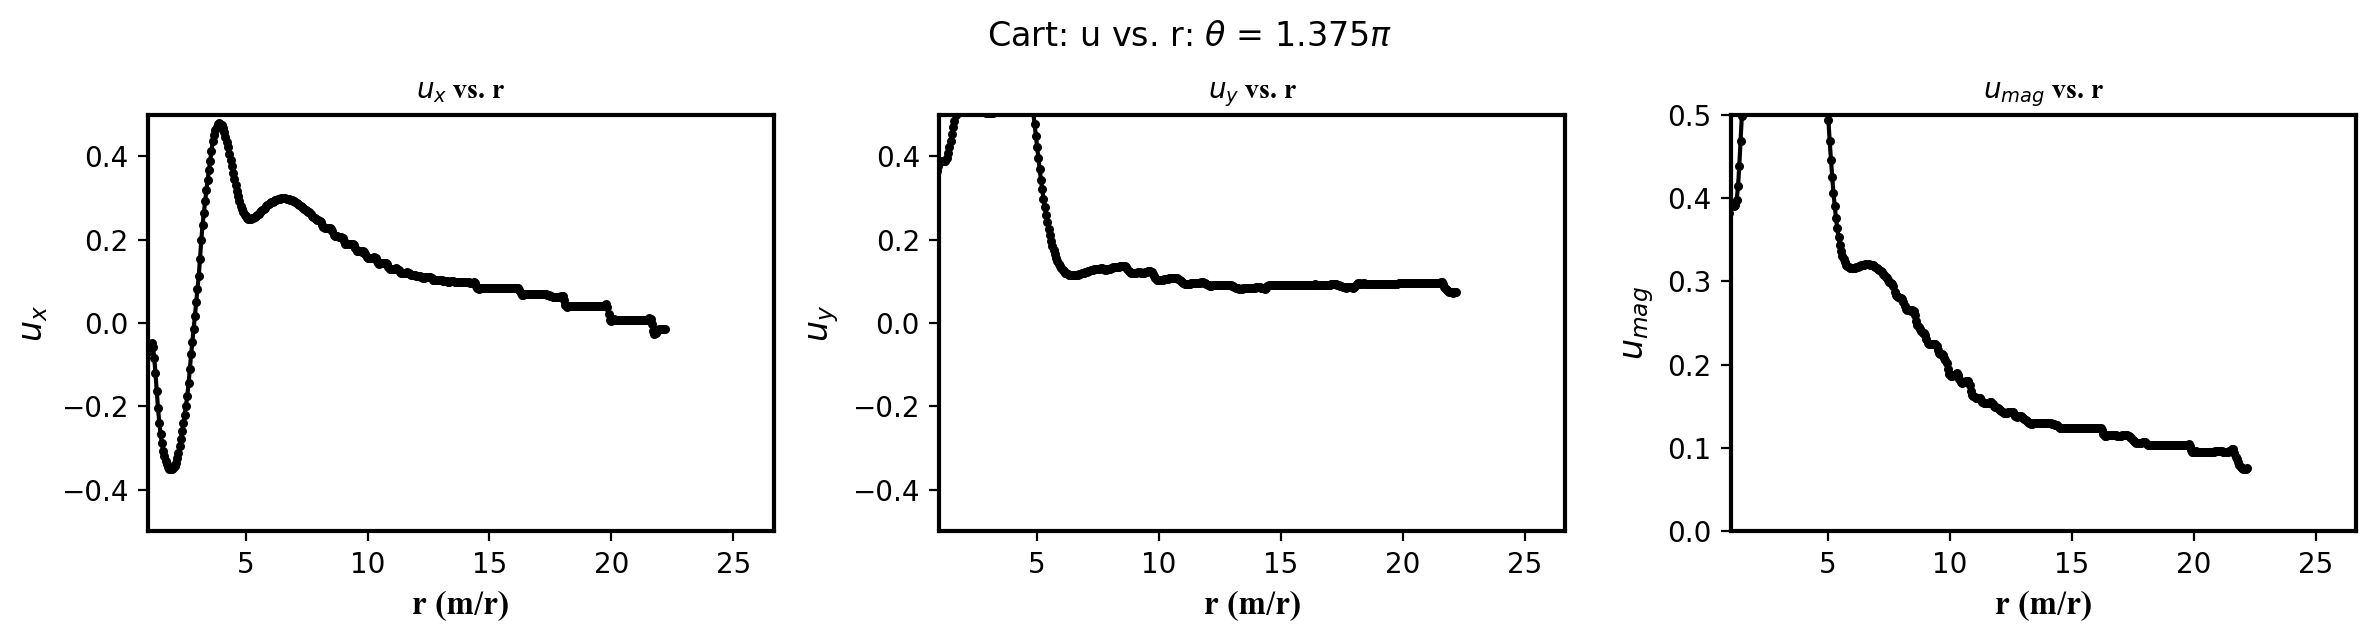

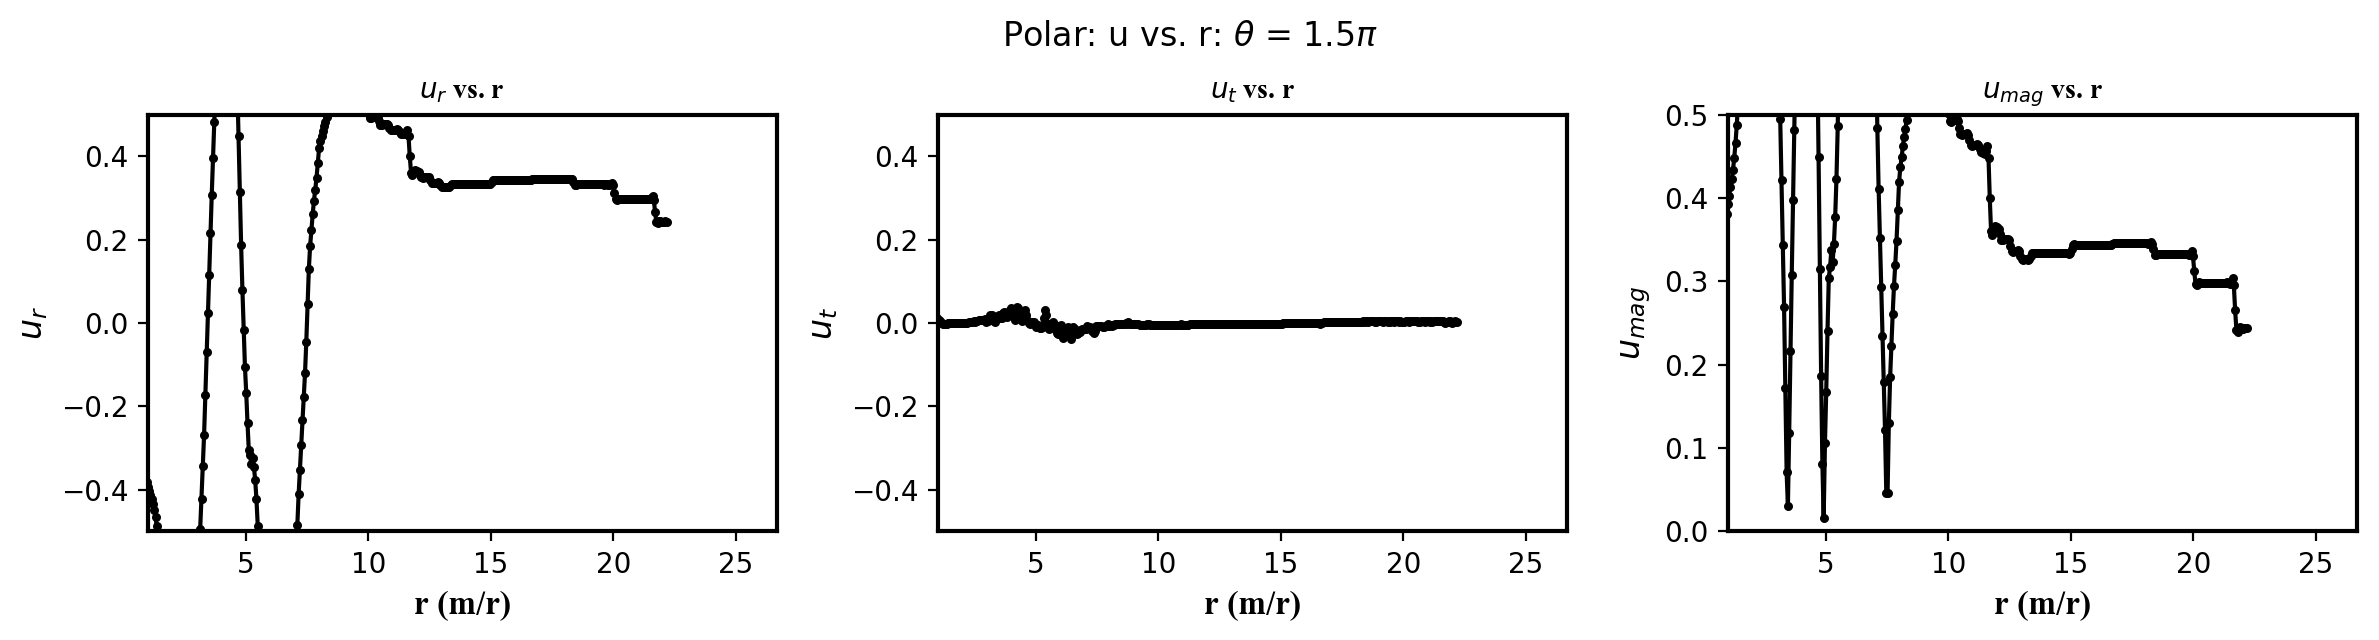

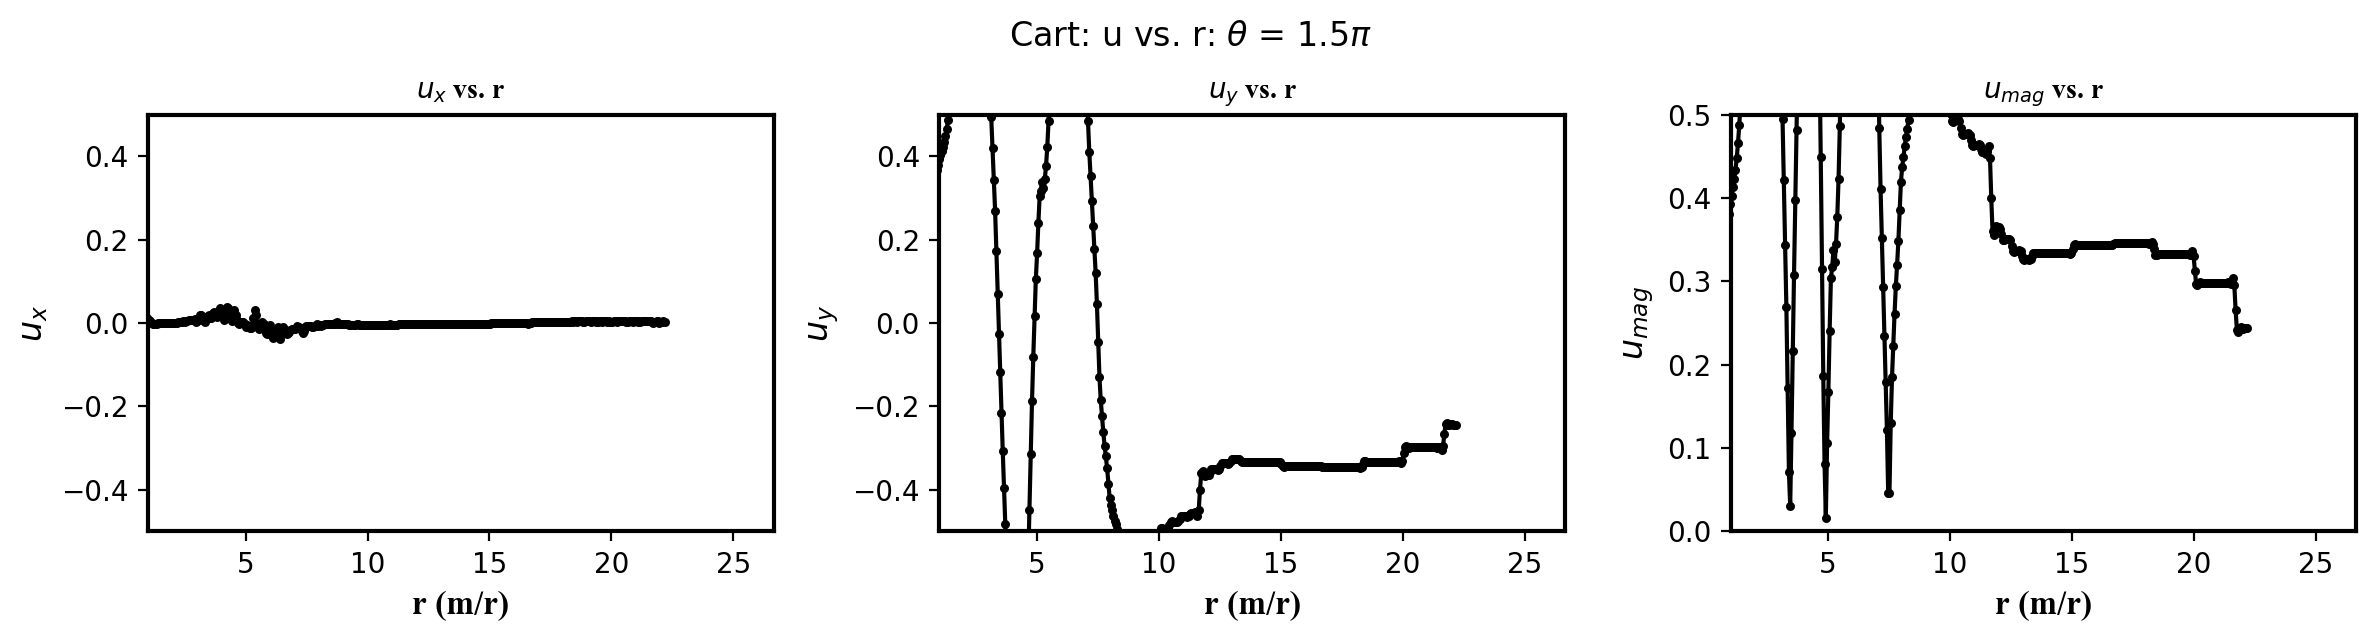

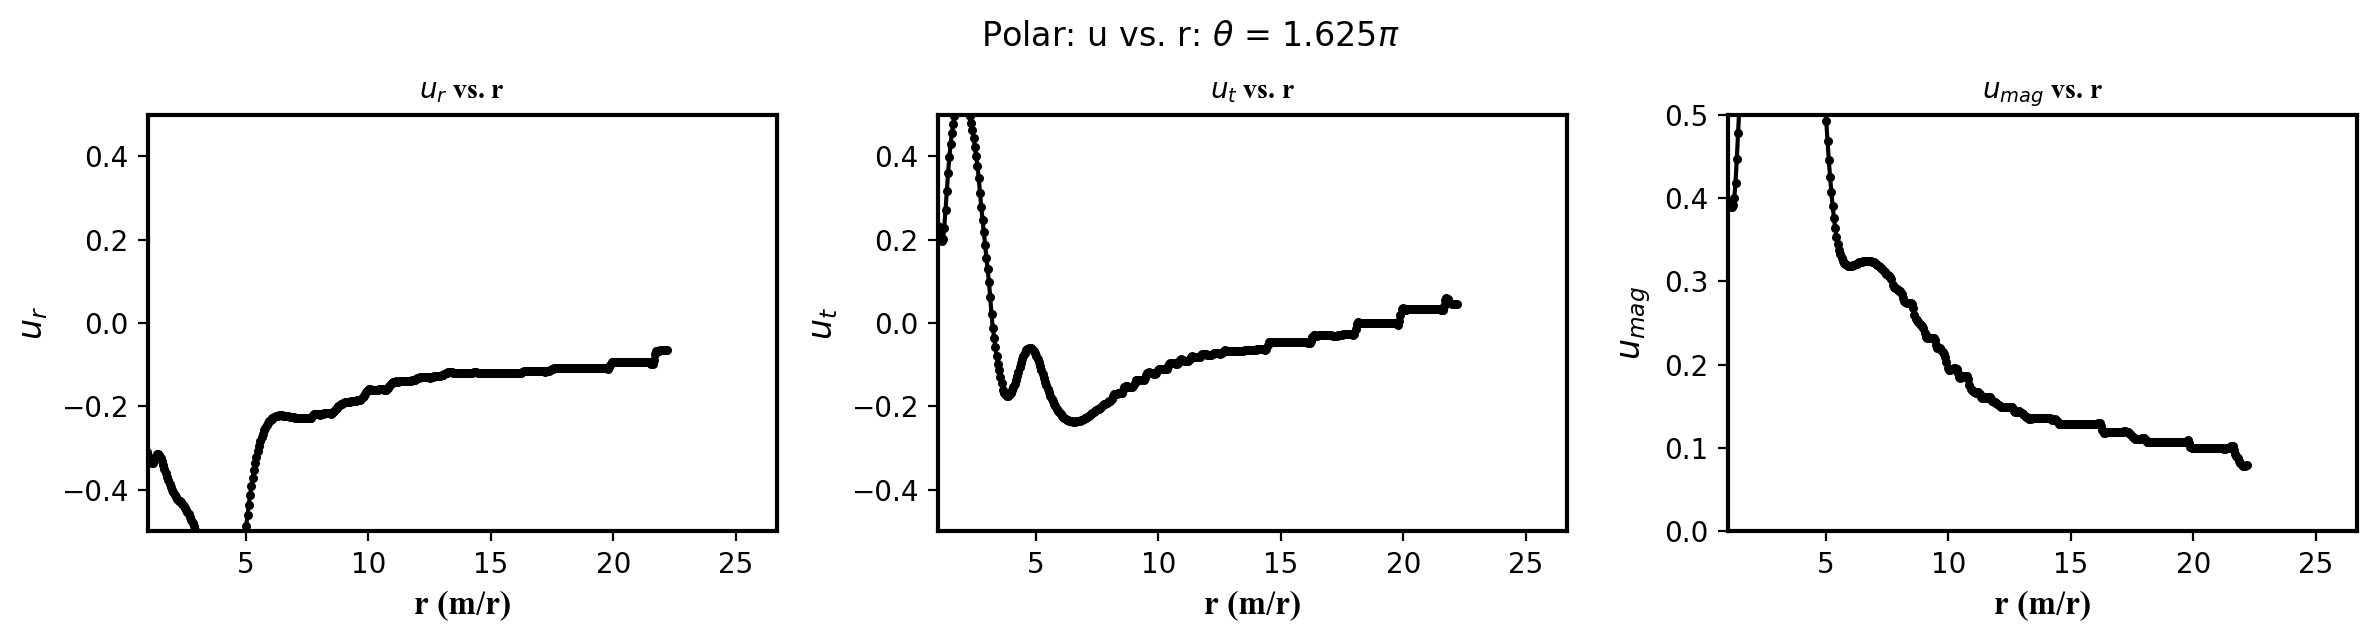

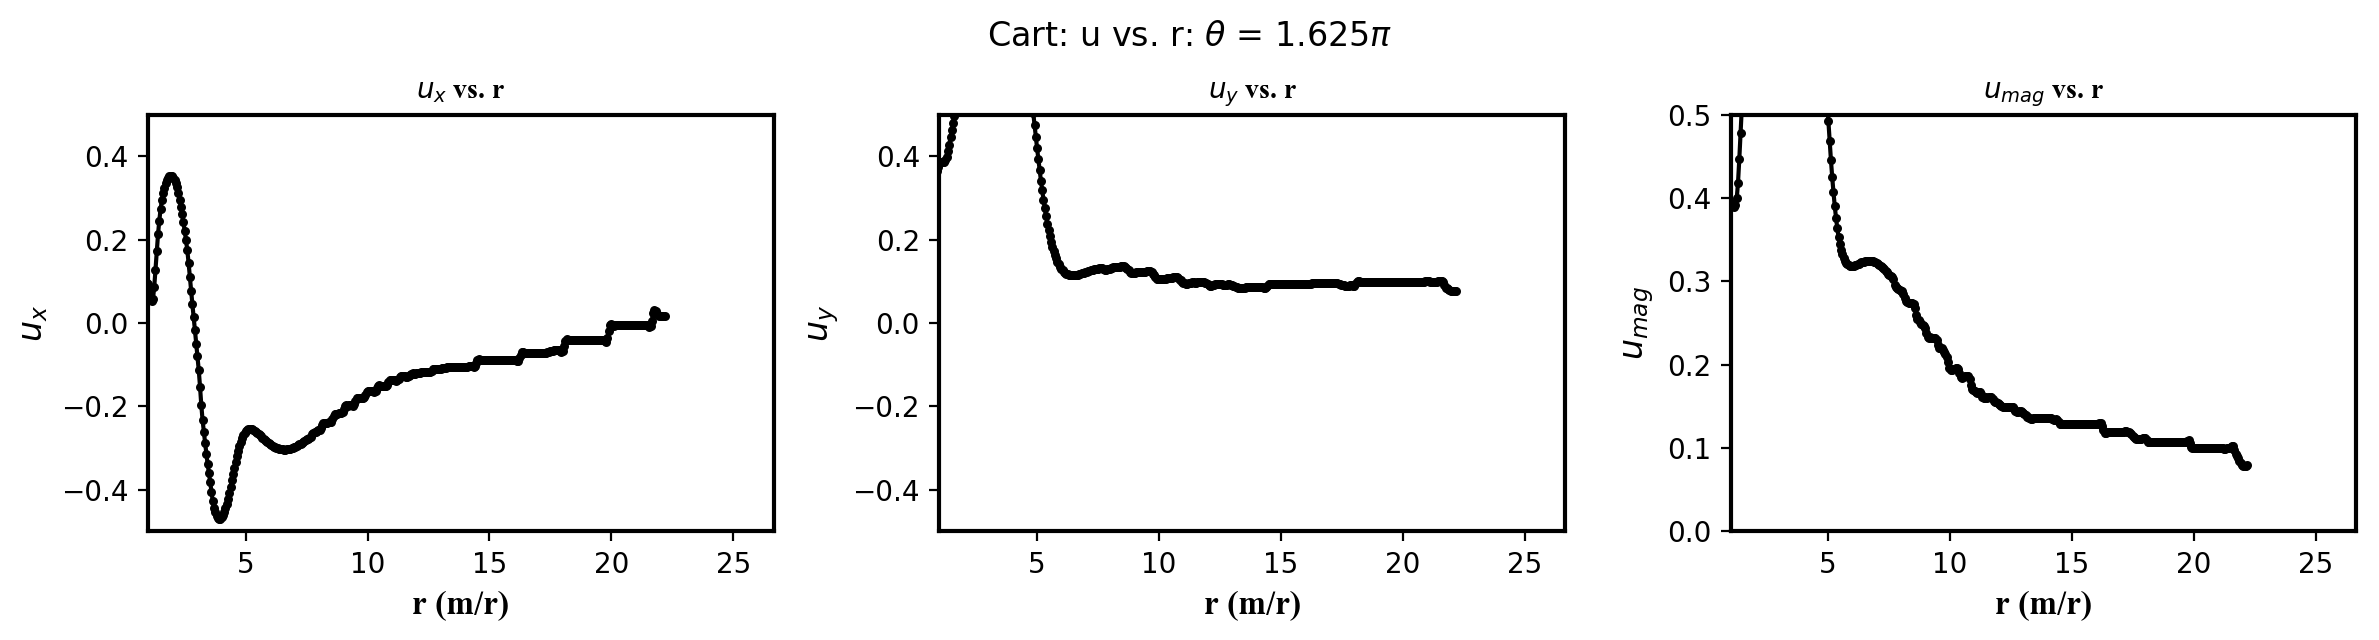

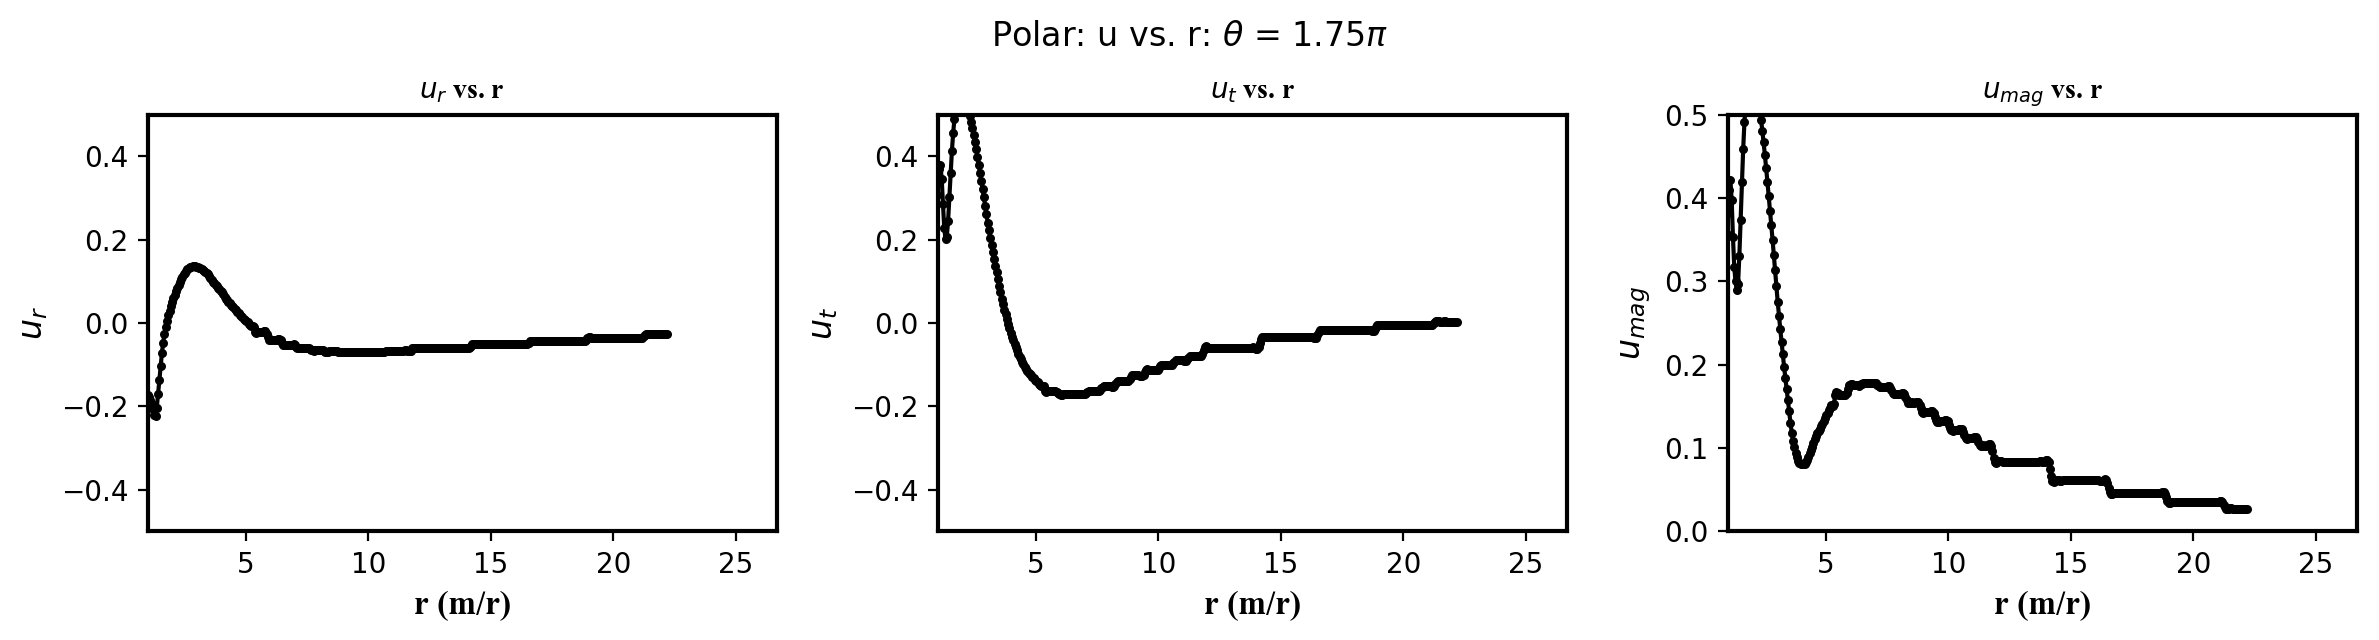

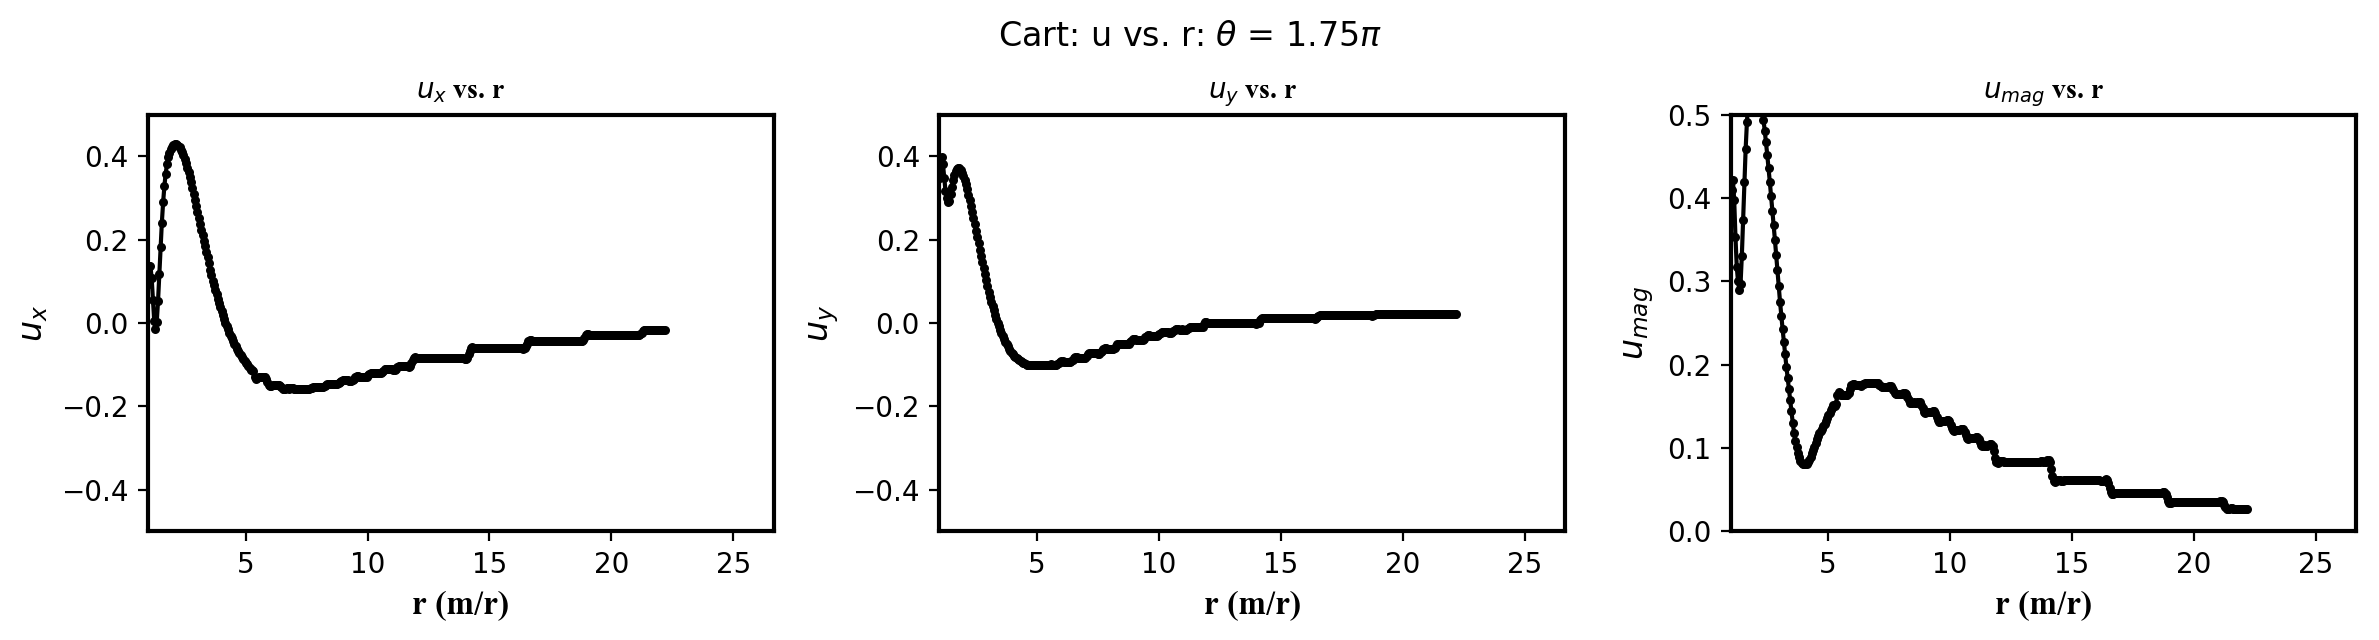

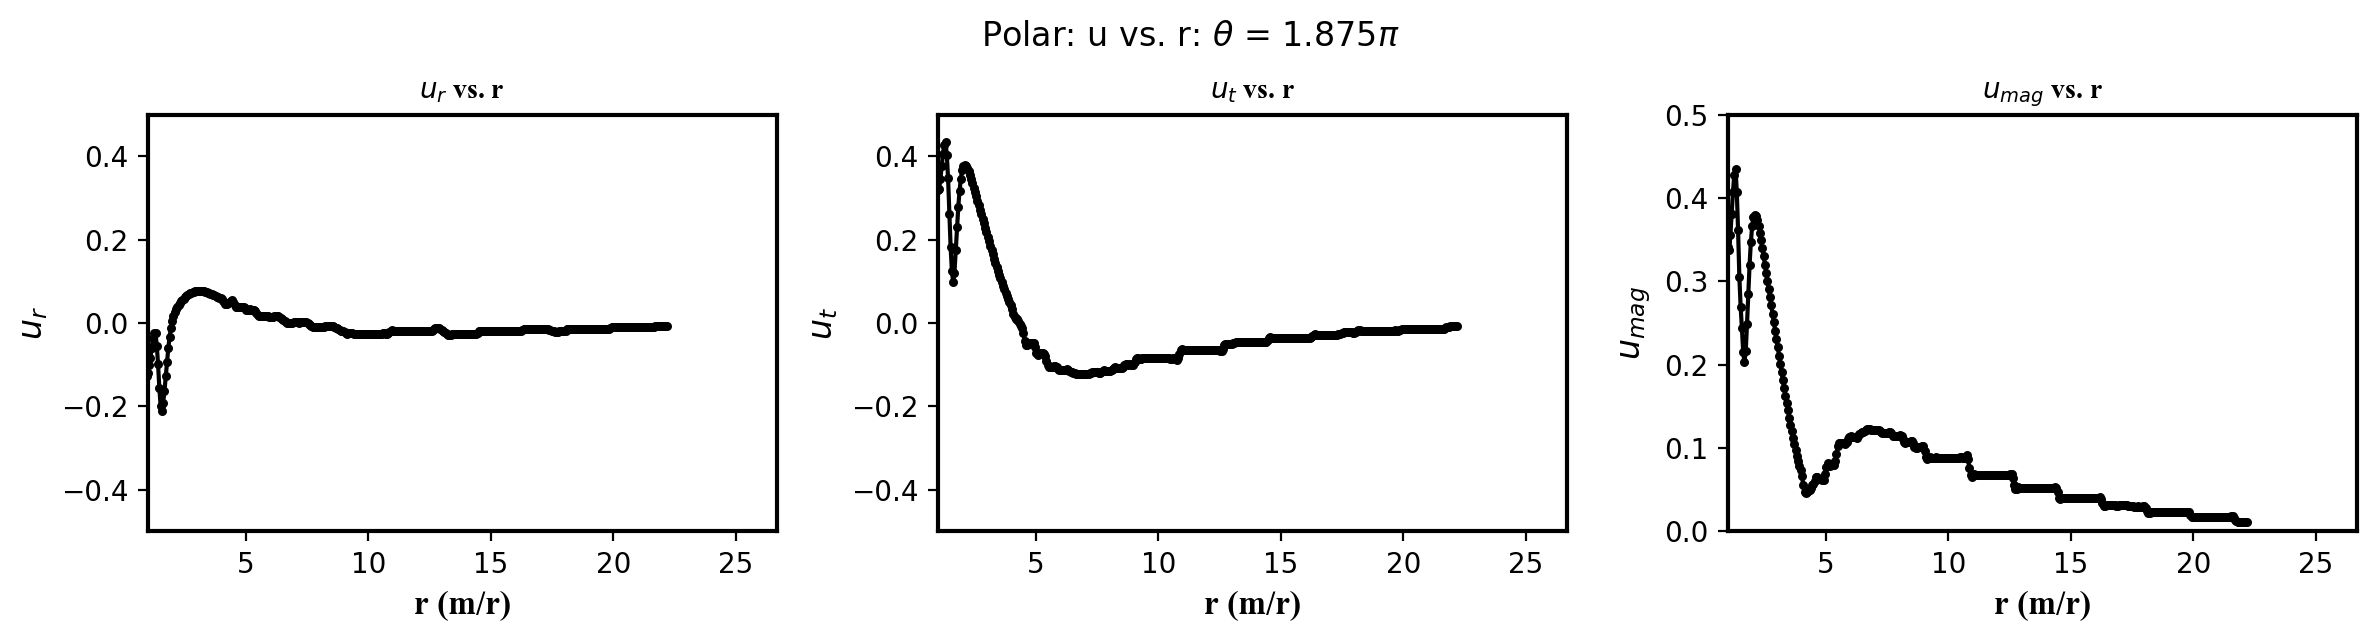

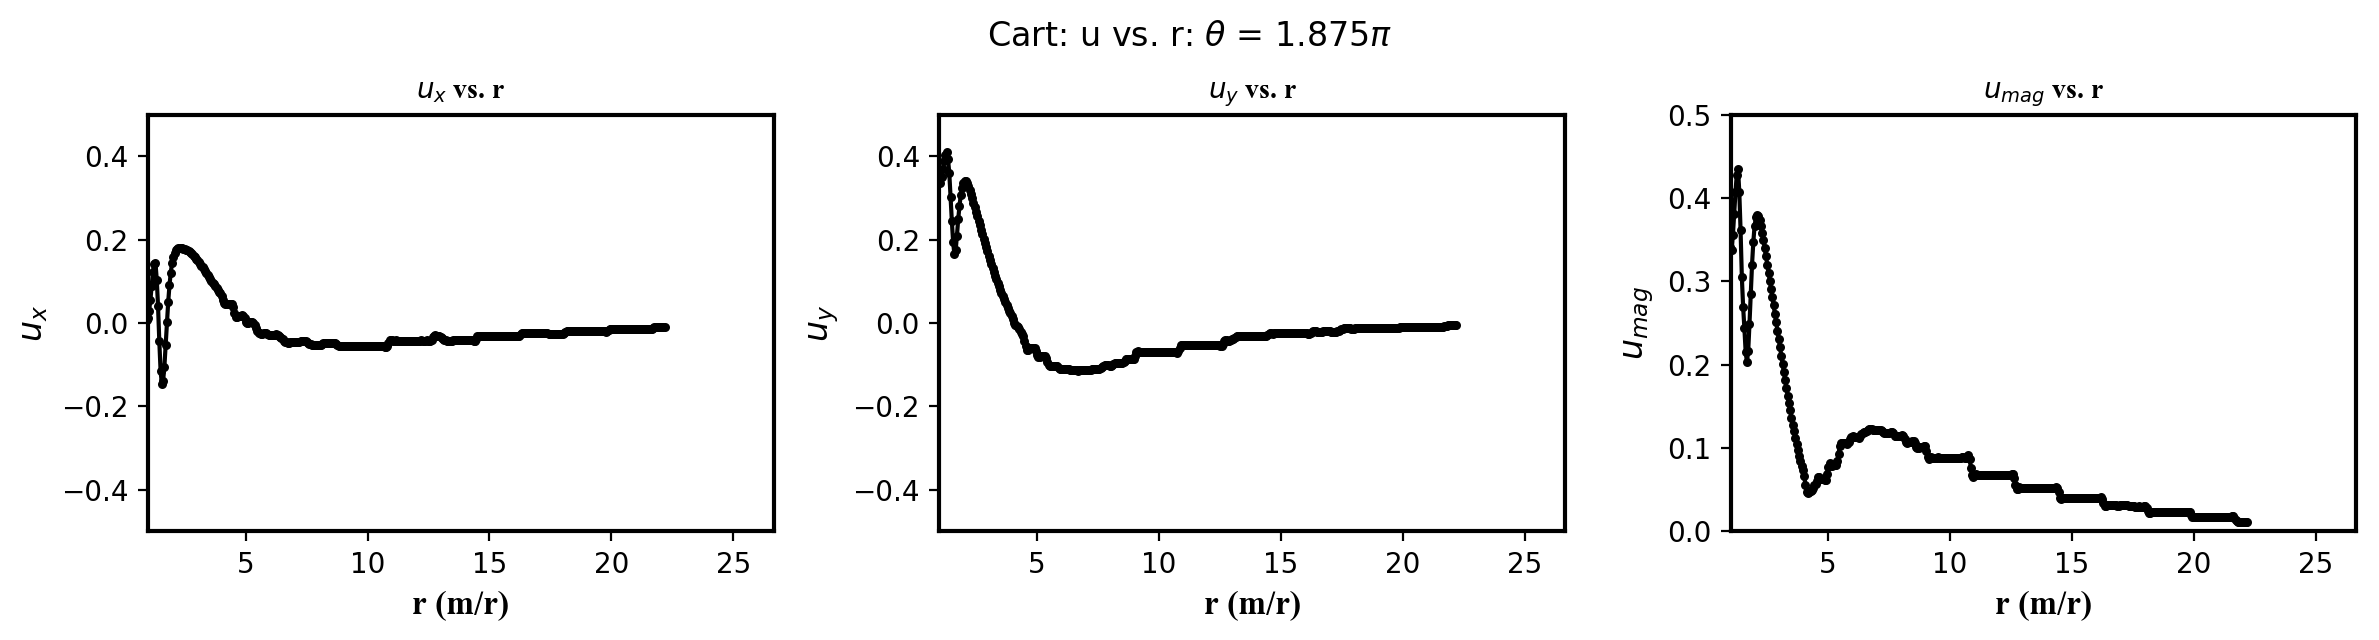

In [9]:
import pandas as pd

#Plot coefficients vs rval for both specified mesh coordinate
def Plot_U_vs_r(data,title,coeff):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(12,3),dpi=200)
    fig.suptitle(title,fontsize=12,y=1.05)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    #We will specify the time in the x-label
    if(coeff == 'cart'):
        ax1.set_title(r'$u_x$ vs. r',fontsize=10,**csfont)
        ax2.set_title(r'$u_y$ vs. r',fontsize=10,**csfont)
        ax3.set_title(r'$u_{mag}$ vs. r',fontsize=10,**csfont)
        ax1.set_ylabel(r'$u_x$',fontsize=12,**csfont)
        ax2.set_ylabel(r'$u_y$',fontsize=12,**csfont)
        ax3.set_ylabel(r'$u_{mag}$',fontsize=12,**csfont)
        val1 = data['Ux'].copy()
        val2 = data['Uy'].copy()
        val3 = data['magU_cart'].copy()
    else:
        ax1.set_title(r'$u_r$ vs. r',fontsize=10,**csfont)
        ax2.set_title(r'$u_t$ vs. r',fontsize=10,**csfont)
        ax3.set_title(r'$u_{mag}$ vs. r',fontsize=10,**csfont)
        ax1.set_ylabel(r'$u_r$',fontsize=12,**csfont)
        ax2.set_ylabel(r'$u_t$',fontsize=12,**csfont)
        ax3.set_ylabel(r'$u_{mag}$',fontsize=12,**csfont)
        val1 = data['Ur'].copy()
        val2 = data['Ut'].copy()
        val3 = data['magU_polar'].copy()
    ax1.set_xlabel('r (m/r)',fontsize=12,**csfont)
    ax2.set_xlabel('r (m/r)',fontsize=12,**csfont)
    ax3.set_xlabel('r (m/r)',fontsize=12,**csfont)
    xval = data['mr'].copy()
    
    #Now that we have the figure all labeled, let's add the force field
    #val1
    ax1.scatter(xval,val1,s=5,c='k')
    ax1.plot(xval,val1,c='k')
    #val2
    ax2.scatter(xval,val2,s=5,c='k')
    ax2.plot(xval,val2,c='k')
    #val3
    ax3.scatter(xval,val3,s=5,c='k')
    ax3.plot(xval,val3,c='k')
    
    ax1.set_xlim(0.15/RSMALL,4.0/RSMALL)
    ax2.set_xlim(0.15/RSMALL,4.0/RSMALL)
    ax3.set_xlim(0.15/RSMALL,4.0/RSMALL)
    ax1.set_ylim(-0.5,0.5)
    ax2.set_ylim(-0.5,0.5)
    ax3.set_ylim(0.0,0.5)
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close()
    return
    
dTheta = 2.0*np.pi/(1.0*m)
#Create Database containing (instUt,instUr,mt,mr)
#Before that is done, we need to convert mx_new and my_new to mr and mt centered around CM
mr_new = np.hypot(newavgMesh[0],newavgMesh[1])
mt_new = np.zeros((m,m))
for idx in range(m):
    for jdx in range(m):
        mt_new[idx,jdx] = np.arctan(newavgMesh[1,idx,jdx]/newavgMesh[0,idx,jdx])
        if(newavgMesh[0,idx,jdx] < 0.0):
            #Shift angle by pi
            mt_new[idx,jdx] += np.pi 
        if(mt_new[idx,jdx] < 0.0):
            mt_new[idx,jdx] += 2.0*np.pi


avgUr, avgUt = newavgU_polar[0], newavgU_polar[1]
avgUx, avgUy = newavgU_cart[0], newavgU_cart[1]
avgDict = {'Ut':avgUt.flatten(),'Ur':avgUr.flatten(),'Ux':avgUx.flatten(),
           'Uy':avgUy.flatten(),'mt':mt_new.flatten(),'mr':mr_new.flatten()}
data = pd.DataFrame(data=avgDict)
#Cut data off where r > 4 - abs(yShift)
data = data[data['mr'] > 0.0]
data = data[data['mr'] < 4.0/RSMALL - abs(yShift[idxTime])]
data = data.sort_values(by=['mr','mt'])
data = data.reset_index(drop=True)
data['magU_polar'] = np.hypot(data['Ur'],data['Ut'])
data['magU_cart'] = np.hypot(data['Ux'],data['Uy'])

#For each theta, find Ux, Uy, magU vs r
#Determine # of distinct theta values
mt_list = data['mt'].tolist()
mt_list = [round(num,6) for num in mt_list]
set_t = set(mt_list)
print('num mt_list = ',len(mt_list))
print('num set_t = ',len(set_t))
tval_list = list(set_t)
tval_list = sorted(tval_list)
tval_list = [num/np.pi for num in tval_list]
#print(tval_list)

#For the thetas in the loop
for idx in range(0,len(set_t),32):
    tval = tval_list[idx]
    tempData = data[data['mt'].round(6) == round(tval*np.pi,6)]
    tempData = tempData.sort_values(by=['mr'])
    tempData.reset_index(drop=True)
    #Plot Ur, Ut, magU_polar vs r
    Plot_U_vs_r(tempData,r'Polar: u vs. r: $\theta$ = '+str(round(tval,4))+'$\pi$','polar')
    #Plot Ux, Uy, magU_cart vs r
    Plot_U_vs_r(tempData,r'Cart: u vs. r: $\theta$ = '+str(round(tval,4))+'$\pi$','cart')


22.1787345075


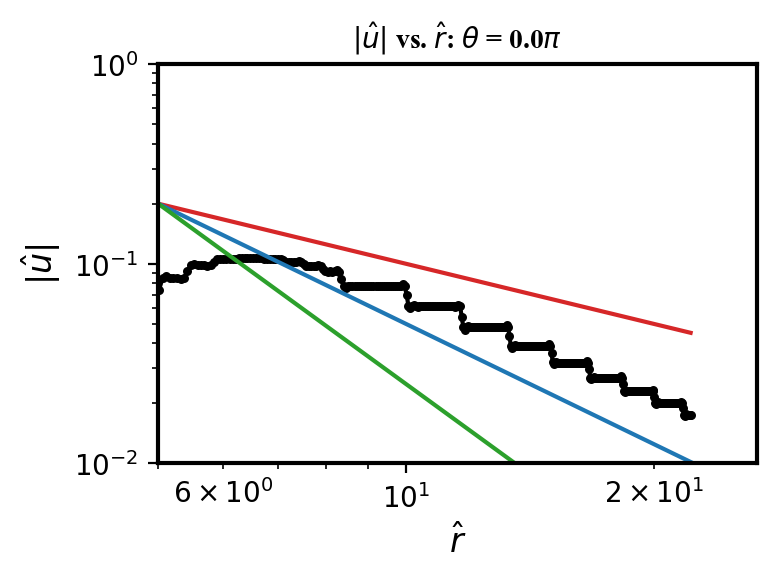

22.1787345075


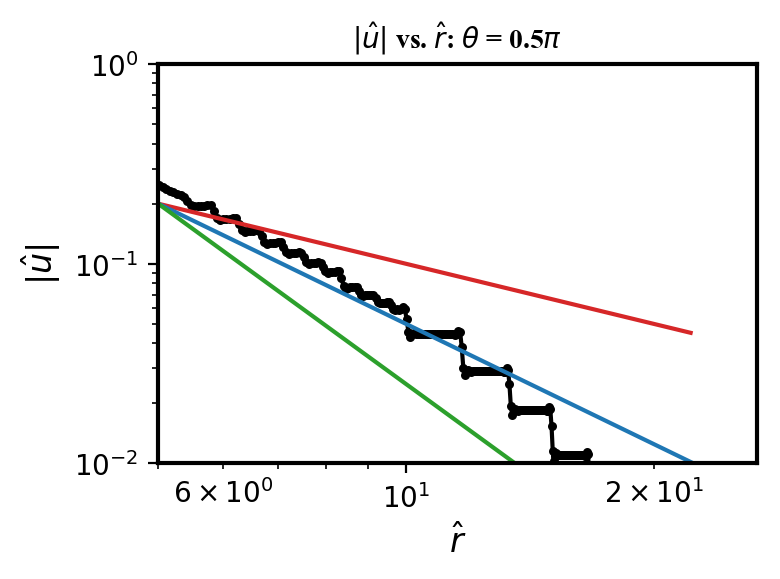

22.1787345075


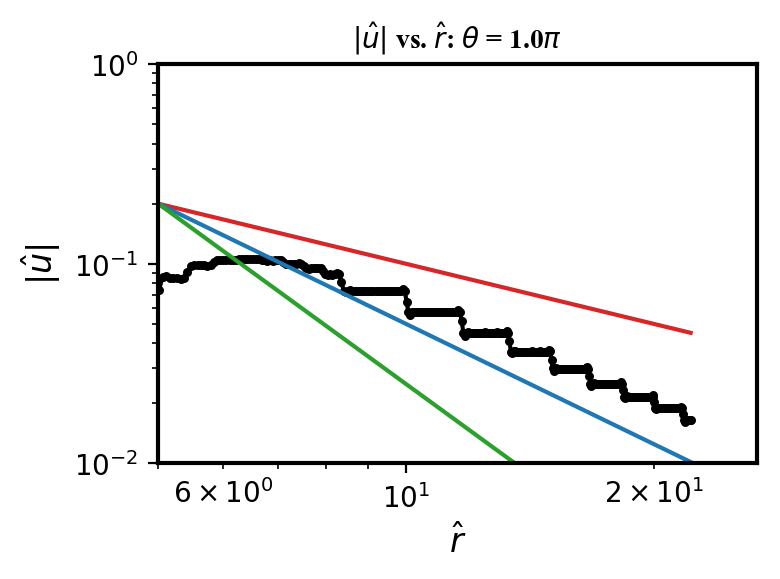

22.1787345075


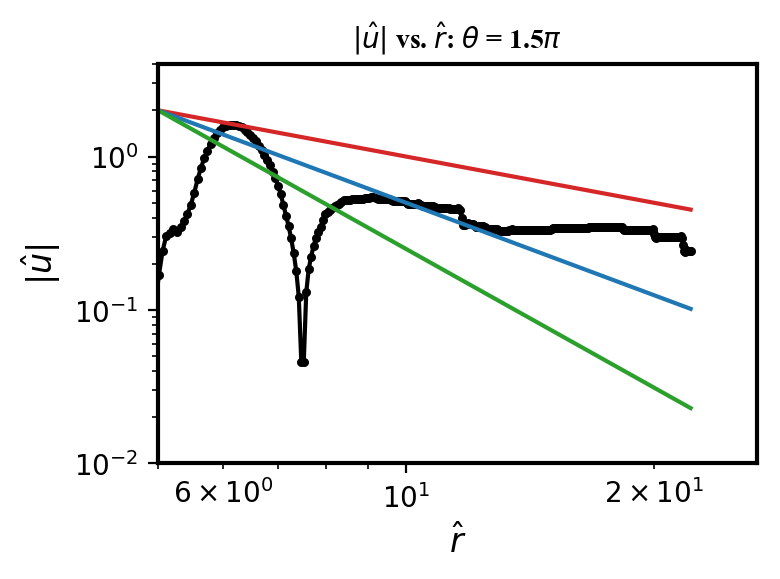

22.1787345075


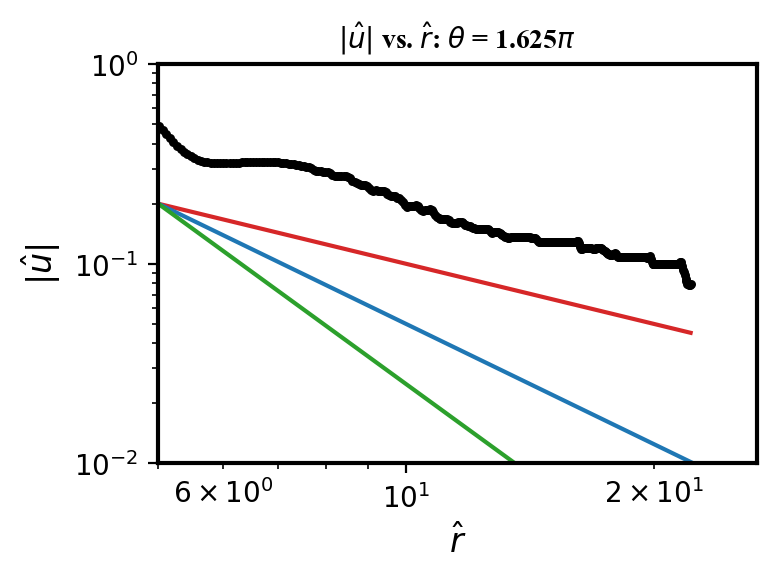

In [18]:
#Plot coefficients vs rval for both specified mesh coordinate
def Plot_U_vs_r(data,tval):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(4,3),dpi=200)
    ax1 = fig.add_subplot(111)
    #We will specify the time in the x-label
    ax1.set_title(r'$|\hat{u}|$ vs. $\hat{r}$: $\theta$ = '+tval+'$\pi$',fontsize=10,**csfont)
    ax1.set_ylabel(r'$|\hat{u}|$',fontsize=12,**csfont)
    val1 = data['magU_cart'].copy()
    #print(np.amin(val1))
    ax1.set_xlabel('$\hat{r}$',fontsize=12,**csfont)
    xval = data['mr'].copy()
    print(np.amax(xval))
    
    #Now that we have the figure all labeled, let's add the force field
    #val1
    ax1.scatter(xval,val1,s=5,c='k',label=None)
    ax1.plot(xval,val1,c='k',label='data')
    
    #Plot Possible Slopes
    slope1val = (xval)**(-1.0)
    slope2val = 5.0*(xval)**(-2.0)
    slope3val = 25.0*(xval)**(-3.0)
    if(float(tval) == 1.5):
        slope1val = 10.0*(xval)**(-1.0)
        slope2val = 50.0*(xval)**(-2.0)
        slope3val = 250.0*(xval)**(-3.0)
    #slope2val = (xval-(5.0-np.sqrt(5)))**(-2.0)
    #slope3val = (xval-(5.0-5.0**(1.0/3.0)))**(-3.0)
    #slope2val = (xval)**(-2.0) + 5.0**(-1.0) - 5.0**(-2.0)
    #slope3val = (xval)**(-3.0) + 5.0**(-1.0) - 5.0**(-3.0)
    
    ax1.plot(xval,slope1val,c='tab:red',label=r'$|u| \propto r^{-1}$')
    ax1.plot(xval,slope2val,c='tab:blue',label=r'$|u| \propto r^{-2}$')
    ax1.plot(xval,slope3val,c='tab:green',label=r'$|u| \propto r^{-3}$')
    #ax1.legend(loc='best',fontsize='x-small')
    
    ax1.set_xlim(5.0,4.0/RSMALL)
    ax1.set_ylim(1.0e-2,1.0)
    if(float(tval) == 1.5):
        ax1.set_ylim(1.0e-2,4.0)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    fig.tight_layout()
    plt.show()
    fig.savefig('LSL_magU_vs_r_theta_'+tval+'pi.png')
    fig.clf()
    plt.close()
    return
                      
#For the thetas in the loop
for idx in range(0,len(set_t),128):
    tval = tval_list[idx]
    tempData = data[data['mt'].round(6) == round(tval*np.pi,6)]
    tempData = tempData.sort_values(by=['mr'])
    tempData.reset_index(drop=True)
    #Plot loglog magU_cart vs r
    Plot_U_vs_r(tempData,str(round(tval,4)))
    
tval = 1.625
tempData = data[data['mt'].round(6) == round(tval*np.pi,6)]
tempData = tempData.sort_values(by=['mr'])
tempData.reset_index(drop=True)
#Plot loglog magU_cart vs r
Plot_U_vs_r(tempData,str(round(tval,4)))
